# **In this notebook we run meK-Means on the dropout simulation settings**

In [1]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import importlib

In [2]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference

In [4]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

**Download data and metadata for analysis**

In [ ]:
#Loom files for simulation data
!wget --content-disposition https://data.caltech.edu/records/mzs5b-72897/files/meK_sim_looms.tar.gz?download=1
!tar -xvf meK_sim_looms.tar.gz

In [ ]:
#Simulation gene annotations

!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/references/sim_genome_polyA_cum_3_0
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/references/sim_genome_polyA_cum_3_1


## **Use *Monod* for technical parameter (sequencing artifacts/bias) recovery**

In [ ]:
!mkdir ./fits

In [17]:
#Define loom and transcriptome for each dataset (Filtered cells beforehand)
#Allen sc, Allen nuc, sc_mix 3cl, sc_mix 5cl, brca1, pbmcs, germ


#No cell barcode filtering, filter for 2k genes, 

#all spliced,unspliced,gene_name,barcode

looms = ['./home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n1.loom',
 './home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n1.loom',
 './home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n1.loom',
 './home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom',
 './home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom',
 './home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom']

transcrips = ['./sim_genome_polyA_cum_3_0',
             './sim_genome_polyA_cum_3_0',
             './sim_genome_polyA_cum_3_0',
             './sim_genome_polyA_cum_3_0',
             './sim_genome_polyA_cum_3_0',
             './sim_genome_polyA_cum_3_1']

datas = [i.replace('./home/tchari/counts/meKMeans_sims/loom/','') for i in looms]
datas = [i.replace('.loom','') for i in datas]

attribute_names =[('unspliced','spliced'),'gene_name','barcode']

dir_strings = []

data_strings = []

#!mkdir /home/tchari/perturbCME/notebooks/fits/meK_techruns_0310
!mkdir ./fits/meK_techruns_0508

for loom,transc,data_name in zip(looms,transcrips,datas):
    dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/meK_techruns_0508',
                                                                 meta=data_name,batch_id=1,\
                                                 n_genes=500,exp_filter_threshold=None,viz=False)
    dir_strings += [dir_string]
    data_strings += [dataset_string]




In [18]:
from timeit import default_timer as timer

In [19]:
#Set bounds of physical params for inference
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
gridsize = [10,11]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:19<00:00,  1.26s/it]


0.04013475234998623  hr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:14<00:00,  1.22s/it]


0.038882489807470444  hr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:22<00:00,  1.29s/it]


0.04108409278444015  hr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:14<00:00,  1.22s/it]


0.038868377337510335  hr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:44<00:00,  1.50s/it]


0.04739295200722861  hr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:16<00:00,  1.24s/it]


0.03944638771997739  hr


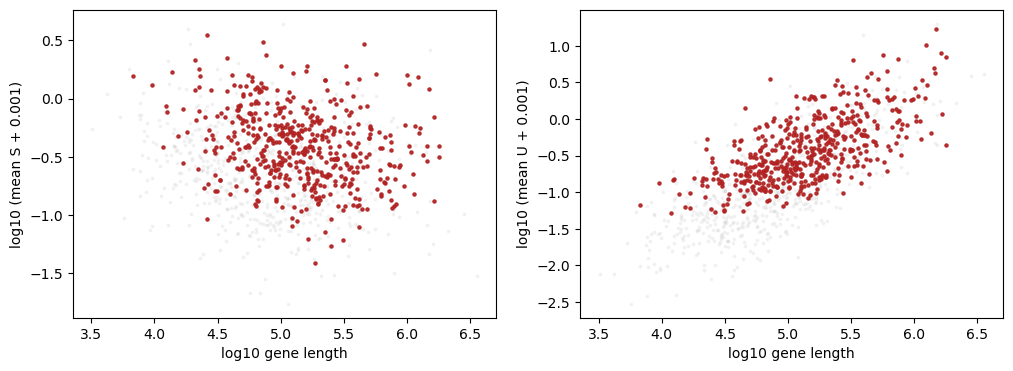

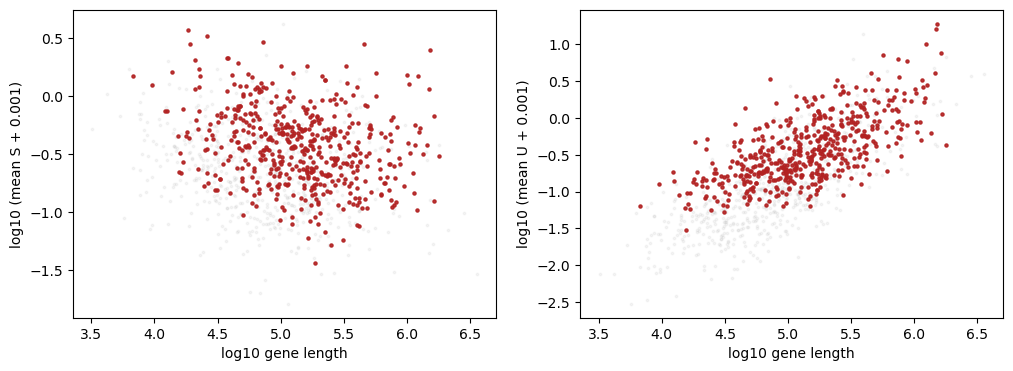

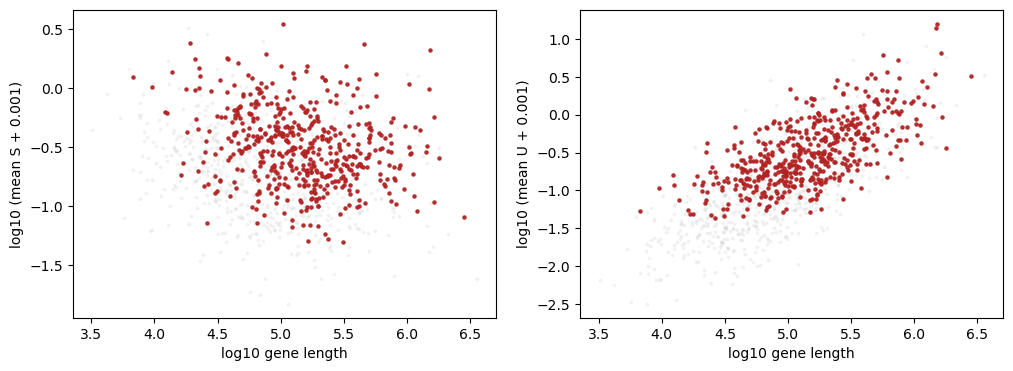

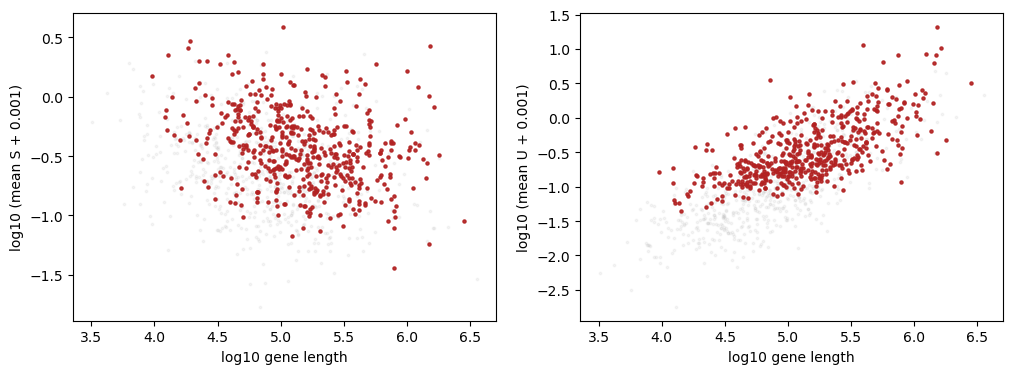

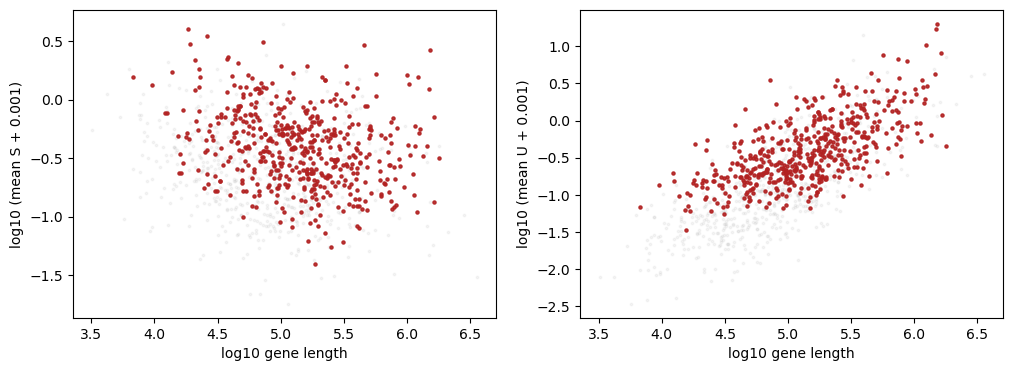

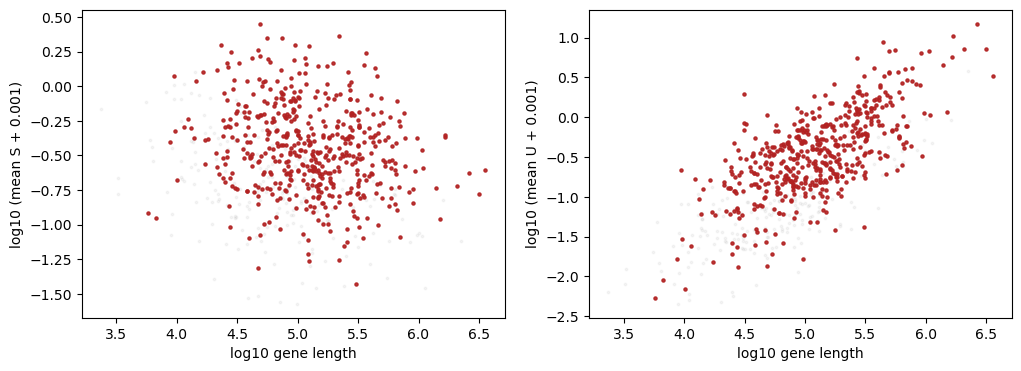

In [20]:
result_strings = []
for i in range(len(data_strings)): 
    #Set biological model
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    #Set up inference params
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                data_strings[i][0],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    
    #Get object for monod processing (from loom)
    
    search_data = monod.extract_data.extract_data(looms[i], transcrips[i], datas[i],
                data_strings[i][0], dir_strings[i], dataset_attr_names=attribute_names,)
    
    #Run inference
    start = timer()
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    end = timer()
    print((end - start)/3600,' hr')

    result_strings.append(full_result_string)

In [21]:
result_strings

['./fits/meK_techruns_0508/gg_240515_029_drop_1perc_sim_k8_n1_1/drop_1perc_sim_k8_n1/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0508/gg_240515_029_drop_5perc_sim_k8_n1_1/drop_5perc_sim_k8_n1/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0508/gg_240515_029_drop_20perc_sim_k8_n1_1/drop_20perc_sim_k8_n1/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0508/gg_240515_029_negctrl_sim_k1_1/negctrl_sim_k1/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0508/gg_240515_029_b_beta_sim_k8_1/b_beta_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0508/gg_240515_029_k_gamma_sim_k8_1/k_gamma_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res']

drop_1perc_sim_k8_n1   (-6.777777777777778, -1.25)
drop_5perc_sim_k8_n1   (-6.222222222222222, -0.6999999999999997)
drop_20perc_sim_k8_n1   (-6.222222222222222, -0.6999999999999997)
negctrl_sim_k1   (-6.777777777777778, -1.25)
b_beta_sim_k8   (-6.777777777777778, -1.25)
k_gamma_sim_k8   (-6.777777777777778, -1.25)


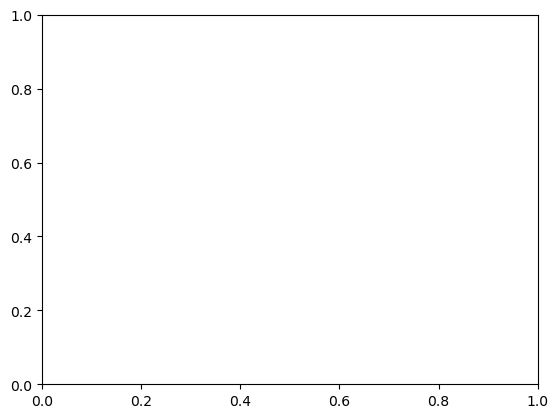

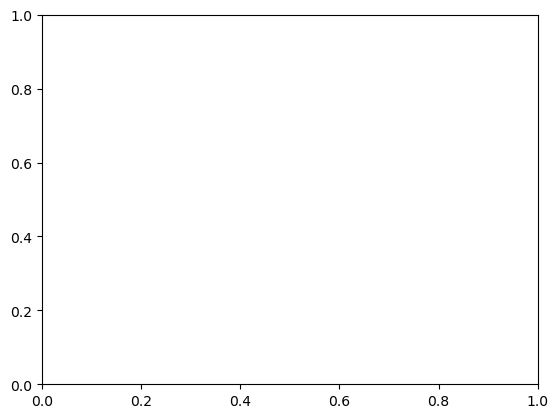

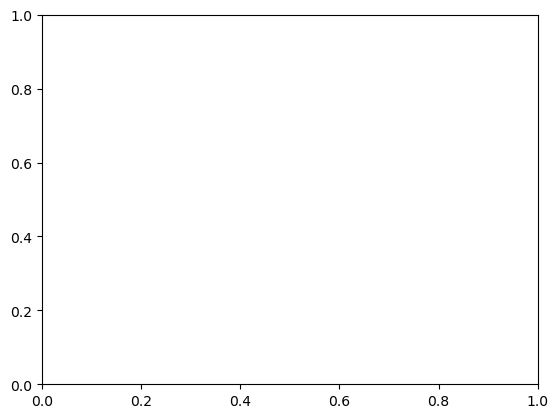

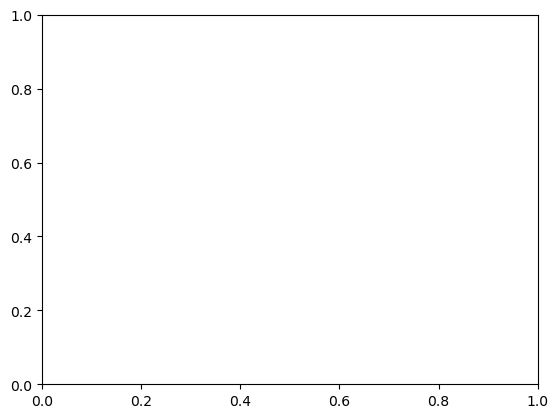

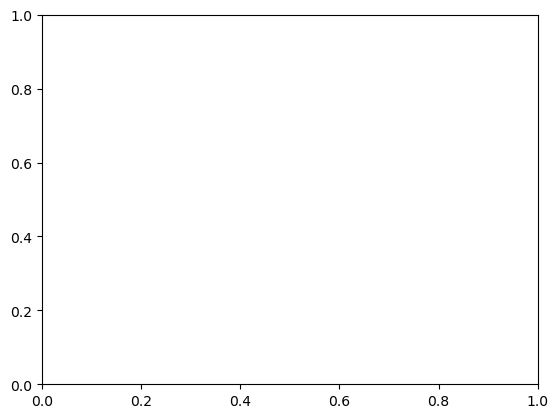

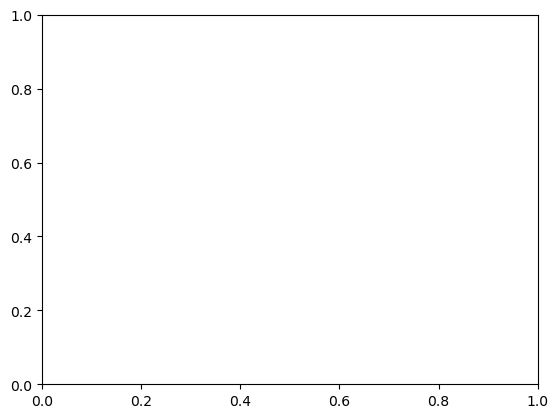

In [22]:
opts = []
for i in range(len(data_strings)): 
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_strings[i]+'/'+datas[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    print(datas[i],' ',sr.samp_optimum)
    opts += [sr.samp_optimum]

In [23]:
# opts = []
# for i in range(len(data_strings)): 
#     sr = monod.analysis.load_search_results(result_strings[i])
#     sd = monod.analysis.load_search_data(dir_strings[i]+'/'+datas[i]+'/raw.sd')
#     fig1,ax1 = plt.subplots(1,1)
#     sr.find_sampling_optimum()
#     print(datas[i],' ',sr.samp_optimum)
#     opts += [sr.samp_optimum]

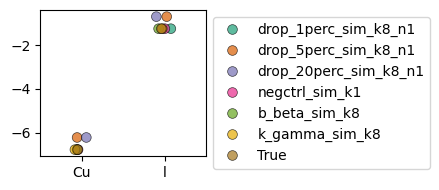

In [28]:
plt.figure(figsize=(4.5,2))
g=sns.stripplot(x=['Cu']*6+['l']*6+['Cu','l'],
                y=list(np.array(opts)[:,0])+list(np.array(opts)[:,1])+[-6.777777777777778, -1.25],
                hue=datas+datas+['True','True'],
                jitter=True,s=7,edgecolor='black',linewidth=0.5,
               palette='Dark2',alpha=0.7)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.savefig('techparams_dropout.pdf')

## **Checking meK-Means performance with simulated dropout**

In [117]:
d_strings  = glob.glob('./home/tchari/counts/meKMeans_sims/loom/*_n*.loom')
d_strings 

['/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n0.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n0.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n2.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n0.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n2.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n2.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n1.loom']

In [118]:
d_strings = d_strings+['./home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom']

In [119]:
attribute_names =[('unspliced','spliced'),'gene_name','barcode']

In [120]:
datas = [i.replace('./home/tchari/counts/meKMeans_sims/loom/','') for i in d_strings]
datas = [i.replace('.loom','') for i in datas]

In [121]:
# to_run = [0,1,2,4] #inds to run

In [122]:
def get_samp(filename):
    if ('5perc' in filename) or ('20perc' in filename):
        return [-6.222222222222222, -0.6999999999999997]
    else:
        return [-6.777777777777778, -1.25]


all_samps = [get_samp(f) for f in d_strings]
        
#samp = [-6.777777777777778, -1.25]

In [123]:
transcriptomes = './sim_genome_polyA_cum_3_0'

In [124]:
sub_d_strings = d_strings #[d_strings[i] for i in to_run]
sub_d_strings

['/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n0.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n0.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n2.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n0.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n2.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8_n2.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8_n1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8_n1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom']

In [125]:
datas_sub = datas #[datas[i] for i in to_run]
datas_sub

['drop_1perc_sim_k8_n1',
 'drop_20perc_sim_k8_n0',
 'drop_5perc_sim_k8_n0',
 'drop_20perc_sim_k8_n2',
 'drop_1perc_sim_k8_n0',
 'drop_5perc_sim_k8_n2',
 'drop_1perc_sim_k8_n2',
 'drop_5perc_sim_k8_n1',
 'drop_20perc_sim_k8_n1',
 'b_beta_sim_k8']

In [104]:
#!rm -r /home/tchari/perturbCME/notebooks/fits/meKruns_drop_0508

In [126]:
# !rm -r /home/tchari/perturbCME/notebooks/fits/meKruns_drop_0521

rm: cannot remove '/home/tchari/perturbCME/notebooks/fits/meKruns_drop_0521': No such file or directory


In [127]:
#For each loom in looms from ./hvg_objs


#!mkdir /home/tchari/perturbCME/notebooks/fits/meKruns_0309
#!mkdir /home/tchari/perturbCME/notebooks/fits/meKruns_drop_0508
!mkdir ./fits/meKruns_drop_0521

dir_strings = []
data_strings = []
result_strings = []

#Save method, clustering, mat_in (U,S, etc), hyper (K or res), hvgs, data, ARI, AMI
meK_res = pd.DataFrame()
meths = []
result = []
mats = []
hyper = []
hvgs = []
data = []
ari = []
ami = []
aics = []

for d in sub_d_strings: 
    
    #Get tech param by keyword (datas) in loom paths
    ind = [i in d for i in datas_sub]
    
    #Inference params for sampling
    tech_tup = list(np.array(all_samps)[ind][0]) #samp
    
    #Preprocessing params for filepaths
    trans = transcriptomes

    data_name = np.array(datas_sub)[ind][0]
    
    
    ds = lp.connect(d)
    g_names = ds.ra[attribute_names[1]]
    num_genes = len(g_names)
    num_cells = len(ds.ca[attribute_names[2]])
    
    U = ds.layers['unspliced'][:,:].T
    S = ds.layers['spliced'][:,:].T
    true_labs = list(ds.ca['subclass_label'])
    ds.close()

    
    print(data_name+' with '+str(num_genes)+' genes')
    
    
   
    Ks = [5,len(np.unique(true_labs)),len(np.unique(true_labs))+5,len(np.unique(true_labs))+10]
        

    for clus in Ks:
       
        #Run Monod preprocessing to set up files for run, leave room for genes to be removed with low U/S
        dir_string,dataset_string = monod.preprocess.construct_batch([d], \
                                                     trans, \
                                                     [data_name], \
                                                     attribute_names=attribute_names,\
                                                     batch_location='./fits/meKruns_drop_0521', \
                                                     meta=data_name+'_K'+str(clus), \
                                                     batch_id=1, \
                                                     n_genes=num_genes,exp_filter_threshold=None,
                                                                     viz=False,genes_to_fit=g_names)
                                                        #num_genes-60 or 100,genes_to_fit=markers
        dir_strings += [dir_string]
        data_strings += [dataset_string]

        #Set model and run meK-Means
        
        #Define bounds for params
        phys_lb = [-3.0, -3, -3 ] 
        phys_ub = [4.2, 2.5, 2.5] 
        samp_lb = tech_tup 
        samp_ub = tech_tup  
        gridsize = [1,1] #Already have tech params
    

        epochs = 10

        # ---------------- meK-Means Inference ---------------- 
        #Define model with bursty transcription and Poisson molecule capture/sampling
        fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

        #Set up mminference parameters
        inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                    dataset_string[0],fitmodel,k=clus,epochs=epochs,use_lengths = True,
                    gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

        #Read in loom file with filtered barcodes
        search_data = monod.extract_data.extract_data(d, trans, data_name,
                    dataset_string[0], dir_string, viz=False, dataset_attr_names=attribute_names)

        #Run inference(fit_all_grid_points()) and Save result file strings
        full_result_string = inference_parameters.fit_all_grid_points(40,search_data) 

        result_strings.append(full_result_string)
        

        # ----------------  Save output ---------------- 
        #Read in results and get cluster assignments
        sr = [monod.analysis.load_search_results(i) for i in full_result_string]
        
        
        cat_assigns = np.array([None]*num_cells) #cat_assigns is empty list of length = no. cell barcodes
        for i in range(len(sr)):
            r = sr[i]
            cat_assigns[r.filt] = r.assigns #denotes which cluster (k), cells were assigned to

        print('No. clus: ',len(np.unique(cat_assigns)))
        

        meths += ['meK-Means']
        result += [cat_assigns]
        mats += ['U,S']
        hyper += [clus]
        hvgs += [num_genes]
        data += [data_name[:-3]] #REMOVE _n_ FROM NAME
        ari += [adjusted_rand_score(true_labs,cat_assigns)]
        ami += [adjusted_mutual_info_score(true_labs,cat_assigns)]
        aics += [sr[0].aic[0]]
        
        print('ARI: ',adjusted_rand_score(true_labs,cat_assigns))


meK_res['Method'] = meths
meK_res['Clustering'] = result
meK_res['Matrices'] = mats
meK_res['Hyperparam'] = hyper
meK_res['HVGs'] = hvgs
meK_res['Data'] = data
meK_res['ARI'] = ari
meK_res['AMI'] = ami
meK_res['AIC'] = aics
    

drop_1perc_sim_k8_n1 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.88s/it]


mstep self.weights:  [0.37660299 0.18429939 0.16160353 0.24362345 0.03387064]
Q Function:  -7586478.367750954




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.02s/it]


mstep self.weights:  [0.3844142  0.19537137 0.16000479 0.2492614  0.01094824]
Q Function:  -7573001.864615648




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.45s/it]


mstep self.weights:  [3.86578418e-01 1.93145464e-01 1.60000076e-01 2.60276042e-01
 2.04821911e-10]
Q Function:  -7568914.066246011




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.96s/it]


mstep self.weights:  [3.85357401e-01 1.94313003e-01 1.60000066e-01 2.60329530e-01
 2.00000000e-10]
Q Function:  -7569094.526771512




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.81s/it]


mstep self.weights:  [3.86183471e-01 1.93585507e-01 1.60000083e-01 2.60230938e-01
 2.00000000e-10]
Q Function:  -7569323.963167947




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.73s/it]


mstep self.weights:  [3.85028283e-01 1.94583321e-01 1.60000069e-01 2.60388328e-01
 2.00000000e-10]
Q Function:  -7566796.244294192




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.91s/it]


mstep self.weights:  [3.86626630e-01 1.93143950e-01 1.60000066e-01 2.60229354e-01
 2.00000000e-10]
Q Function:  -7569952.340355741




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.62s/it]


mstep self.weights:  [3.85224313e-01 1.94389048e-01 1.60000075e-01 2.60386563e-01
 2.00000000e-10]
Q Function:  -7566754.550773511




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.80s/it]


mstep self.weights:  [3.86658541e-01 1.93134038e-01 1.60000065e-01 2.60207356e-01
 2.00000000e-10]
Q Function:  -7569941.395367166




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.50s/it]


mstep self.weights:  [3.85224359e-01 1.94389005e-01 1.60000075e-01 2.60386561e-01
 2.00000000e-10]
Q Function:  -7566754.551875923

No. clus:  4
ARI:  0.6484797322709706



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.65s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.48s/it]


mstep self.weights:  [0.10590159 0.18639029 0.2200145  0.00570475 0.01187098 0.25157657
 0.01336257 0.08085179 0.06137291 0.06295405]
Q Function:  -7600861.827196565




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.55s/it]


mstep self.weights:  [1.00343110e-01 1.95627553e-01 2.39092279e-01 2.00000000e-10
 2.00000000e-10 2.59768783e-01 3.08926733e-09 9.43741633e-02
 4.56936247e-02 6.51004844e-02]
Q Function:  -7561837.625099569




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.07s/it]


mstep self.weights:  [1.00101970e-01 1.96654844e-01 2.48084502e-01 2.00000000e-10
 2.00000000e-10 2.59918767e-01 2.00000000e-10 7.72408602e-02
 3.52406647e-02 8.27583920e-02]
Q Function:  -7559629.158934471




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:53<00:00,  7.59s/it]


mstep self.weights:  [1.00023820e-01 1.96241081e-01 2.61740399e-01 2.00000000e-10
 2.00000000e-10 2.60162767e-01 2.00000000e-10 6.22501844e-02
 2.18319034e-02 9.77498448e-02]
Q Function:  -7557057.519277114




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.75s/it]


mstep self.weights:  [9.96428162e-02 1.97241253e-01 2.82884922e-01 2.00000000e-10
 2.00000000e-10 2.60233645e-01 2.00000000e-10 4.68234371e-02
 9.90614308e-08 1.13173827e-01]
Q Function:  -7555313.497378288




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.46s/it]


mstep self.weights:  [9.95647790e-02 1.96897427e-01 2.83160419e-01 2.00000000e-10
 2.00000000e-10 2.60377355e-01 2.00000000e-10 4.52508772e-02
 2.00000800e-10 1.14749141e-01]
Q Function:  -7554072.066485693




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it]


mstep self.weights:  [9.95320280e-02 1.97222413e-01 2.82602593e-01 2.00000000e-10
 2.00000000e-10 2.60638542e-01 2.00000000e-10 4.39801678e-02
 2.00000017e-10 1.16024256e-01]
Q Function:  -7558703.969088895




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it]


mstep self.weights:  [9.95749339e-02 1.96216330e-01 2.83913512e-01 2.00000000e-10
 2.00000000e-10 2.60295205e-01 2.00000000e-10 4.17949263e-02
 2.00000001e-10 1.18205091e-01]
Q Function:  -7557086.861112336




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.73s/it]


mstep self.weights:  [9.95739877e-02 1.97690235e-01 2.82495640e-01 2.00000000e-10
 2.00000000e-10 2.60240392e-01 2.00000000e-10 1.98737325e-02
 2.00000001e-10 1.40126012e-01]
Q Function:  -7555964.82535103




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.32s/it]


mstep self.weights:  [9.95491323e-02 1.95634673e-01 2.84159519e-01 2.00000000e-10
 2.00000000e-10 2.60652598e-01 2.00000000e-10 4.08972369e-04
 2.00000015e-10 1.59595104e-01]
Q Function:  -7561171.409922232

No. clus:  6
ARI:  0.7893365368163708



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.96s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.90s/it]


mstep self.weights:  [0.12604751 0.04452585 0.03784871 0.1233348  0.00688728 0.25233753
 0.12164488 0.12519698 0.05193828 0.02499527 0.01869175 0.00922844
 0.0115369  0.0193953  0.0263905 ]
Q Function:  -7634617.417556103




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]


mstep self.weights:  [1.83319676e-01 5.77548327e-03 8.11653894e-02 1.52723597e-01
 1.99999999e-10 1.91412490e-01 1.26553906e-01 1.67317961e-01
 8.68176949e-02 3.03798840e-03 1.12124894e-08 2.00000182e-10
 2.00004254e-10 1.01672747e-08 1.87579220e-03]
Q Function:  -7595158.688976665




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.01s/it]


mstep self.weights:  [2.01944293e-01 1.99999999e-10 9.30701985e-02 1.28000718e-01
 1.99999999e-10 2.36201995e-01 7.95353924e-02 1.63320452e-01
 9.79269496e-02 1.99999999e-10 2.00044249e-10 1.99999999e-10
 1.99999999e-10 2.00000000e-10 1.99999999e-10]
Q Function:  -7569885.510763914




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.79s/it]


mstep self.weights:  [2.00542570e-01 1.99999999e-10 1.06475896e-01 1.08896725e-01
 1.99999999e-10 2.53001265e-01 6.99270893e-02 1.61036319e-01
 1.00120134e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7556727.796335696




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.83s/it]


mstep self.weights:  [2.00118903e-01 1.99999999e-10 1.13810325e-01 1.02416888e-01
 1.99999999e-10 2.59298117e-01 6.36987268e-02 1.60471671e-01
 1.00185367e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7553824.4326804




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.75s/it]


mstep self.weights:  [2.02622376e-01 1.99999999e-10 1.06157817e-01 1.02045675e-01
 1.99999999e-10 2.63116447e-01 6.13318392e-02 1.61234436e-01
 1.03491408e-01 1.99999999e-10 2.00000004e-10 1.99999999e-10
 1.99999999e-10 2.00000000e-10 1.99999999e-10]
Q Function:  -7555678.539142147




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.09s/it]


mstep self.weights:  [2.02341102e-01 1.99999999e-10 1.07831220e-01 1.01513582e-01
 1.99999999e-10 2.61872914e-01 6.06077148e-02 1.61101003e-01
 1.04732462e-01 1.99999999e-10 2.00000002e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7555539.751423209




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.17s/it]


mstep self.weights:  [2.02370970e-01 1.99999999e-10 1.08586562e-01 1.01032674e-01
 1.99999999e-10 2.62395586e-01 5.98939505e-02 1.60946829e-01
 1.04773425e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7549281.0540363435




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.43s/it]


mstep self.weights:  [2.01721317e-01 1.99999999e-10 1.09038744e-01 1.00694006e-01
 1.99999999e-10 2.61765765e-01 5.98411580e-02 1.61088443e-01
 1.05850566e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.00000002e-10 1.99999999e-10]
Q Function:  -7556963.200058381




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:51<00:00,  7.38s/it]


mstep self.weights:  [2.01563429e-01 1.99999999e-10 1.09441029e-01 1.00277637e-01
 1.99999999e-10 2.61301078e-01 5.93575731e-02 1.60843182e-01
 1.07216071e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7552732.327683563

No. clus:  7
ARI:  0.9522922940428544



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.13s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.24s/it]


mstep self.weights:  [0.14748571 0.01260225 0.07763377 0.01347176 0.01217847 0.04462523
 0.07016832 0.15530127 0.03060818 0.04720858 0.02693328 0.00168956
 0.01957216 0.06661238 0.0470394  0.01103649 0.03361363 0.10766014
 0.03305759 0.04150185]
Q Function:  -7657085.181229082




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:59<00:00,  3.71s/it]


mstep self.weights:  [2.07877015e-01 2.32594040e-05 1.63002072e-01 2.00370034e-10
 3.34345993e-04 4.40742760e-02 1.14745817e-01 1.77771505e-01
 3.64330845e-02 1.18023591e-02 3.02713885e-04 1.99999999e-10
 5.24445282e-04 8.85347635e-02 3.78455391e-02 4.68423391e-10
 4.18199690e-03 1.06300926e-01 1.74037824e-03 4.50550239e-03]
Q Function:  -7594145.103678048




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:53<00:00,  5.90s/it]


mstep self.weights:  [2.02394869e-01 2.00000056e-10 1.94875802e-01 2.00000001e-10
 1.99999999e-10 3.18618415e-02 8.31767295e-02 1.90034873e-01
 2.54963166e-02 3.66887264e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.44865916e-01 2.50247615e-02 2.00003660e-10
 1.99999999e-10 1.02268888e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7577729.09271242




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:53<00:00,  5.97s/it]


mstep self.weights:  [2.00247101e-01 2.00000003e-10 2.43125501e-01 2.00000000e-10
 1.99999999e-10 3.85203021e-03 8.57457799e-02 1.76477458e-01
 1.72460951e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.70128920e-01 2.97947165e-03 1.99999999e-10
 1.99999999e-10 1.00197641e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7571529.316753185




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.92s/it]


mstep self.weights:  [1.96712189e-01 1.99999999e-10 2.79873596e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.08792396e-01 1.61709660e-01
 2.07644821e-03 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.51061873e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.97738356e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7568958.183563672




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.48s/it]


mstep self.weights:  [1.95545893e-01 1.99999999e-10 2.85421670e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.54173178e-01 1.60044260e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.05284019e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.95309779e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7566630.415812025




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.65s/it]


mstep self.weights:  [1.95972489e-01 1.99999999e-10 2.84711277e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.09281175e-01 1.60000059e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.50553761e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.94812370e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7555920.234023939




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it]


mstep self.weights:  [1.97525103e-01 1.99999999e-10 2.83259147e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.02373829e-01 1.60000101e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.57443525e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.93982908e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7559588.45337976




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.59s/it]


mstep self.weights:  [1.95622114e-01 1.99999999e-10 2.84636281e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 6.82637174e-02 1.60272438e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.91805986e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.93994611e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7566443.844424428




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.17s/it]


mstep self.weights:  [1.96348183e-01 1.99999999e-10 2.84201048e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.46385884e-02 1.60402772e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.45010004e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.93994016e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7573935.6040871255

No. clus:  6
ARI:  0.7648640918630993
drop_20perc_sim_k8_n0 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.44s/it]


mstep self.weights:  [0.64896267 0.10477243 0.12177439 0.01295167 0.11153884]
Q Function:  -6741410.778603099




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.08s/it]


mstep self.weights:  [8.07617771e-01 4.30977009e-02 8.07438436e-02 2.00000000e-10
 6.85406842e-02]
Q Function:  -6738685.995290299




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.87s/it]


mstep self.weights:  [8.54861283e-01 8.98667389e-04 4.34644777e-02 2.00000000e-10
 1.00775571e-01]
Q Function:  -6735421.159315259




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:56<00:00, 18.83s/it]


mstep self.weights:  [8.29518005e-01 2.00000000e-10 5.47200526e-02 2.00000000e-10
 1.15761942e-01]
Q Function:  -6727371.2017651005




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.36s/it]


mstep self.weights:  [8.40689505e-01 2.00000000e-10 9.27895052e-03 2.00000000e-10
 1.50031544e-01]
Q Function:  -6722953.562892408




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:49<00:00, 24.95s/it]


mstep self.weights:  [8.40256667e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 1.59743332e-01]
Q Function:  -6718351.751985171




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:49<00:00, 24.66s/it]


mstep self.weights:  [8.40128990e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 1.59871009e-01]
Q Function:  -6718171.020149904




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:49<00:00, 24.95s/it]


mstep self.weights:  [8.40128812e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 1.59871188e-01]
Q Function:  -6718171.0207154155




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:49<00:00, 24.90s/it]


mstep self.weights:  [8.40128812e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 1.59871188e-01]
Q Function:  -6718171.020716631




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:49<00:00, 24.79s/it]


mstep self.weights:  [8.40128812e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 1.59871188e-01]
Q Function:  -6718171.020716634

No. clus:  2
ARI:  0.1307598461721085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.75s/it]


mstep self.weights:  [0.42621017 0.03219719 0.00198192 0.15738705 0.03972275 0.04644158
 0.02759357 0.24792717 0.00239389 0.01814471]
Q Function:  -6717296.632611565




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.96s/it]


mstep self.weights:  [5.48905129e-01 9.26187879e-03 2.00000000e-10 1.60730778e-01
 1.55343913e-02 5.40593335e-03 1.87422136e-04 2.59969136e-01
 2.00000000e-10 5.33191322e-06]
Q Function:  -6696736.813618366




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.93s/it]


mstep self.weights:  [5.79697487e-01 2.00000000e-10 2.00000000e-10 1.60359283e-01
 2.01192729e-10 2.00000000e-10 2.00000000e-10 2.59943228e-01
 2.00000000e-10 2.26295069e-10]
Q Function:  -6695543.435527733




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.08s/it]


mstep self.weights:  [5.79939650e-01 2.00000000e-10 2.00000000e-10 1.60245681e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814668e-01
 2.00000000e-10 2.00001167e-10]
Q Function:  -6694669.67485314




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.05s/it]


mstep self.weights:  [5.79939823e-01 2.00000000e-10 2.00000000e-10 1.60245562e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814614e-01
 2.00000000e-10 2.00001031e-10]
Q Function:  -6694669.674572609




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.33s/it]


mstep self.weights:  [5.79939823e-01 2.00000000e-10 2.00000000e-10 1.60245561e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814614e-01
 2.00000000e-10 2.00001031e-10]
Q Function:  -6694669.674573044




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.82s/it]


mstep self.weights:  [5.79939823e-01 2.00000000e-10 2.00000000e-10 1.60245561e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814614e-01
 2.00000000e-10 2.00001031e-10]
Q Function:  -6694669.674573042




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.86s/it]


mstep self.weights:  [5.79939823e-01 2.00000000e-10 2.00000000e-10 1.60245561e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814614e-01
 2.00000000e-10 2.00001031e-10]
Q Function:  -6694669.674573044




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.30s/it]


mstep self.weights:  [5.79939823e-01 2.00000000e-10 2.00000000e-10 1.60245561e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814614e-01
 2.00000000e-10 2.00001031e-10]
Q Function:  -6694669.674573044




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.09s/it]


mstep self.weights:  [5.79939823e-01 2.00000000e-10 2.00000000e-10 1.60245561e-01
 2.00000000e-10 2.00000000e-10 2.00000000e-10 2.59814614e-01
 2.00000000e-10 2.00001031e-10]
Q Function:  -6694669.674573044

No. clus:  3
ARI:  0.40420012242841974



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.95s/it]


mstep self.weights:  [0.31661684 0.03023125 0.09606234 0.10693662 0.02785641 0.01270879
 0.05446295 0.00643652 0.01455752 0.04356425 0.02577899 0.02945015
 0.04503996 0.15506837 0.03522905]
Q Function:  -6744498.408984455




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:01<00:00,  5.10s/it]


mstep self.weights:  [4.30710480e-01 1.28373354e-03 9.39876096e-02 1.49017920e-01
 5.31881461e-03 1.02891097e-09 4.10442896e-02 1.99999999e-10
 1.99999999e-10 1.58599334e-02 5.27107272e-04 1.05988101e-03
 1.93850658e-02 2.39863040e-01 1.94212378e-03]
Q Function:  -6718092.119107591




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.71s/it]


mstep self.weights:  [4.42687761e-01 1.99999999e-10 1.08513142e-01 1.60284987e-01
 1.99999999e-10 1.99999999e-10 2.41652101e-02 1.99999999e-10
 1.99999999e-10 3.63130568e-03 1.99999999e-10 1.99999999e-10
 8.14351422e-04 2.59903241e-01 1.99999999e-10]
Q Function:  -6700165.304082166




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.97s/it]


mstep self.weights:  [3.96083906e-01 1.99999999e-10 1.82793700e-01 1.60462349e-01
 1.99999999e-10 1.99999999e-10 1.89517348e-04 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60470526e-01 1.99999999e-10]
Q Function:  -6693530.0508017335




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.46s/it]


mstep self.weights:  [3.43156192e-01 1.99999999e-10 2.36118011e-01 1.60435499e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60290296e-01 1.99999999e-10]
Q Function:  -6688891.535177668




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.20s/it]


mstep self.weights:  [3.21336157e-01 1.99999999e-10 2.58079209e-01 1.60416077e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60168555e-01 1.99999999e-10]
Q Function:  -6684642.512545511




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.79s/it]


mstep self.weights:  [2.90275926e-01 1.99999999e-10 2.89071543e-01 1.60441568e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60210961e-01 1.99999999e-10]
Q Function:  -6685506.345487795




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.69s/it]


mstep self.weights:  [2.63865645e-01 1.99999999e-10 3.15899075e-01 1.60310657e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.59924621e-01 1.99999999e-10]
Q Function:  -6683390.611012642




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.33s/it]


mstep self.weights:  [2.24012258e-01 1.99999999e-10 3.55711106e-01 1.60199537e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60077097e-01 1.99999999e-10]
Q Function:  -6683351.471001344




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.17s/it]


mstep self.weights:  [2.02841849e-01 1.99999999e-10 3.77035427e-01 1.60022398e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60100324e-01 1.99999999e-10]
Q Function:  -6681534.801920114

No. clus:  4
ARI:  0.6656419318715026



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.07s/it]


mstep self.weights:  [0.29227913 0.04792088 0.01672031 0.048968   0.12992596 0.00634243
 0.01715074 0.02039269 0.00763419 0.01754815 0.01439984 0.00177567
 0.01803669 0.12371667 0.00580103 0.00352148 0.00066148 0.05849347
 0.16130995 0.00740124]
Q Function:  -6756114.154221953




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:55<00:00,  6.92s/it]


mstep self.weights:  [3.98899087e-01 2.87642245e-02 5.95998103e-08 1.54377576e-02
 1.46288599e-01 1.99999999e-10 3.84560791e-07 4.11691057e-03
 1.99999999e-10 5.00008239e-09 1.99999999e-10 1.99999999e-10
 5.04849887e-07 1.94453896e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 4.95743206e-02 1.62464250e-01 1.99999999e-10]
Q Function:  -6710476.32784165




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.02s/it]


mstep self.weights:  [3.83615049e-01 6.25266698e-03 2.00000004e-10 1.99999999e-10
 2.49511331e-01 1.99999999e-10 2.00000404e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00992475e-10 1.97686257e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.00917598e-03 1.59925516e-01 1.99999999e-10]
Q Function:  -6687235.118872334




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.17s/it]


mstep self.weights:  [3.81141651e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59673923e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000866e-10 1.99424104e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760319e-01 1.99999999e-10]
Q Function:  -6681240.253073671




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.77s/it]


mstep self.weights:  [3.80875864e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59800657e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000782e-10 1.99563453e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760022e-01 1.99999999e-10]
Q Function:  -6680851.641427539




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.40s/it]


mstep self.weights:  [3.80875574e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59800716e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000783e-10 1.99563660e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760047e-01 1.99999999e-10]
Q Function:  -6680851.641934667




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.59s/it]


mstep self.weights:  [3.80875574e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59800716e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000783e-10 1.99563660e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760047e-01 1.99999999e-10]
Q Function:  -6680851.641936434




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.30s/it]


mstep self.weights:  [3.80875574e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59800716e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000783e-10 1.99563660e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760047e-01 1.99999999e-10]
Q Function:  -6680851.641936437




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.56s/it]


mstep self.weights:  [3.80875574e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59800716e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000783e-10 1.99563660e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760047e-01 1.99999999e-10]
Q Function:  -6680851.641936436




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.25s/it]


mstep self.weights:  [3.80875574e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59800716e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000783e-10 1.99563660e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.59760047e-01 1.99999999e-10]
Q Function:  -6680851.641936436

No. clus:  4
ARI:  0.6605043639203951
drop_5perc_sim_k8_n0 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.85s/it]


mstep self.weights:  [0.54000634 0.02823073 0.16287448 0.15427549 0.11461297]
Q Function:  -7424378.353153251




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.87s/it]


mstep self.weights:  [0.57858083 0.00123373 0.16018007 0.18692967 0.0730757 ]
Q Function:  -7408233.877041817




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.50s/it]


mstep self.weights:  [5.79838955e-01 2.00000000e-10 1.60160782e-01 2.12309008e-01
 4.76912543e-02]
Q Function:  -7405766.137719133




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.51s/it]


mstep self.weights:  [5.79841250e-01 2.00000000e-10 1.60161905e-01 2.52609652e-01
 7.38719274e-03]
Q Function:  -7407433.046100596




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.97s/it]


mstep self.weights:  [5.79835763e-01 2.00000000e-10 1.60161905e-01 2.60002331e-01
 2.00000000e-10]
Q Function:  -7402811.017872223




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.63s/it]


mstep self.weights:  [5.79835763e-01 2.00000000e-10 1.60161905e-01 2.60002331e-01
 2.00000000e-10]
Q Function:  -7402811.017872216




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.76s/it]


mstep self.weights:  [5.79835763e-01 2.00000000e-10 1.60161905e-01 2.60002331e-01
 2.00000000e-10]
Q Function:  -7402811.017872216




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.13s/it]


mstep self.weights:  [5.79835763e-01 2.00000000e-10 1.60161905e-01 2.60002331e-01
 2.00000000e-10]
Q Function:  -7402811.017872216




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.98s/it]


mstep self.weights:  [5.79835763e-01 2.00000000e-10 1.60161905e-01 2.60002331e-01
 2.00000000e-10]
Q Function:  -7402811.017872216

No. clus:  3
ARI:  0.40549011041914007



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.89s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


mstep self.weights:  [0.2004757  0.00101415 0.2600997  0.09564886 0.01287601 0.25537594
 0.00817682 0.0079332  0.00232112 0.1560785 ]
Q Function:  -7417255.133861793




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.39s/it]


mstep self.weights:  [2.00008543e-01 2.00000000e-10 2.80080887e-01 1.00000579e-01
 2.00000000e-10 2.60000216e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.59909775e-01]
Q Function:  -7370211.280382005




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.36s/it]


mstep self.weights:  [1.99994557e-01 2.00000000e-10 2.80005361e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.27658746




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.48s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387095




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.85s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387094




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.48s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387094




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.12s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387094




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.28s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387094




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.27s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387094




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.19s/it]


mstep self.weights:  [1.99994558e-01 2.00000000e-10 2.80005359e-01 1.00000013e-01
 2.00000000e-10 2.60000022e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000046e-01]
Q Function:  -7369157.276387094

No. clus:  5
ARI:  0.8044211716279841



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.95s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.95s/it]


mstep self.weights:  [0.17788242 0.04827162 0.01456419 0.00804311 0.01038379 0.19716221
 0.04623289 0.01196015 0.00696863 0.00990333 0.03386922 0.11895717
 0.10231426 0.18138383 0.03210319]
Q Function:  -7442091.930783594




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.26s/it]


mstep self.weights:  [2.39623239e-01 5.76952695e-03 6.44123933e-04 1.99999999e-10
 1.99999999e-10 2.55960853e-01 3.12633139e-02 2.01224375e-10
 1.99999999e-10 1.99999999e-10 5.24793752e-03 1.59471753e-01
 9.99675956e-02 2.00897530e-01 1.15412704e-03]
Q Function:  -7384882.050481138




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it]


mstep self.weights:  [2.53246236e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.59956588e-01 2.68083874e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000095e-01
 9.99421522e-02 2.00046540e-01 1.99999999e-10]
Q Function:  -7373446.401069302




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it]


mstep self.weights:  [2.53778311e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60000000e-01 2.62326637e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000056e-01
 9.99997524e-02 1.99989214e-01 1.99999999e-10]
Q Function:  -7369955.986820393




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it]


mstep self.weights:  [2.54304974e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60000002e-01 2.57056573e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000049e-01
 9.99997184e-02 1.99989597e-01 1.99999999e-10]
Q Function:  -7369948.3075904315




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it]


mstep self.weights:  [2.54211472e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60000002e-01 2.57973812e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000045e-01
 9.99997199e-02 1.99991378e-01 1.99999999e-10]
Q Function:  -7369614.653986374




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.49s/it]


mstep self.weights:  [2.54211246e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60000002e-01 2.57976036e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000045e-01
 9.99997200e-02 1.99991381e-01 1.99999999e-10]
Q Function:  -7369614.652238432




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.46s/it]


mstep self.weights:  [2.54211246e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60000002e-01 2.57976036e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000045e-01
 9.99997200e-02 1.99991381e-01 1.99999999e-10]
Q Function:  -7369614.652238427




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it]


mstep self.weights:  [2.54211246e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60000002e-01 2.57976036e-02 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000045e-01
 9.99997200e-02 1.99991381e-01 1.99999999e-10]
Q Function:  -7369614.652238427

No. clus:  6
ARI:  0.8372393526371664



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  3.02s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.19s/it]


mstep self.weights:  [0.1117689  0.04020943 0.03856512 0.01569817 0.0231986  0.02629602
 0.0102695  0.01600327 0.00921441 0.07272588 0.07016883 0.1226797
 0.02880415 0.14665088 0.02396796 0.03688578 0.04583276 0.088021
 0.05058114 0.0224585 ]
Q Function:  -7465740.871247851




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:01<00:00,  3.60s/it]


mstep self.weights:  [2.19541438e-01 2.26797022e-02 1.69308708e-02 2.00000069e-10
 3.27058883e-03 2.07163853e-02 2.00000410e-10 8.54009699e-03
 1.99999999e-10 2.64728196e-02 1.06507974e-01 1.60562898e-01
 6.67959574e-03 1.85276466e-01 1.08211881e-02 1.15068185e-02
 4.72905257e-03 1.49738191e-01 3.86510026e-02 7.37491192e-03]
Q Function:  -7423240.221613044




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:01<00:00,  6.87s/it]


mstep self.weights:  [2.75616064e-01 2.00552229e-10 1.32248602e-04 1.99999999e-10
 1.99999999e-10 2.57962099e-03 1.99999999e-10 2.00818402e-10
 1.99999999e-10 1.25638269e-02 2.41311472e-01 1.60071334e-01
 1.99999999e-10 1.94322797e-01 2.02335980e-10 1.97508702e-09
 1.99999999e-10 1.06519432e-01 6.88319999e-03 1.99999999e-10]
Q Function:  -7397814.963722863




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.99s/it]


mstep self.weights:  [2.80356669e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.59999555e-01 1.60000058e-01
 1.99999999e-10 1.99993001e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96507136e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7372273.896399112




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.80s/it]


mstep self.weights:  [2.80385465e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.60000022e-01 1.60000049e-01
 1.99999999e-10 1.99994262e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96201991e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7371699.43529045




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.88s/it]


mstep self.weights:  [2.80385474e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.60000022e-01 1.60000049e-01
 1.99999999e-10 1.99994261e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96201912e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7371699.435158576




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.82s/it]


mstep self.weights:  [2.80385474e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.60000022e-01 1.60000049e-01
 1.99999999e-10 1.99994261e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96201912e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7371699.435158552




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.03s/it]


mstep self.weights:  [2.80385474e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.60000022e-01 1.60000049e-01
 1.99999999e-10 1.99994261e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96201912e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7371699.435158552




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.67s/it]


mstep self.weights:  [2.80385474e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.60000022e-01 1.60000049e-01
 1.99999999e-10 1.99994261e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96201912e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7371699.435158552




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.35s/it]


mstep self.weights:  [2.80385474e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.60000022e-01 1.60000049e-01
 1.99999999e-10 1.99994261e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 9.96201912e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7371699.435158552

No. clus:  5
ARI:  0.8035062216246179
drop_20perc_sim_k8_n2 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.53s/it]


mstep self.weights:  [0.53616373 0.15727502 0.04117257 0.00390987 0.26147881]
Q Function:  -6714774.74426612




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.79s/it]


mstep self.weights:  [5.72366991e-01 1.60063570e-01 7.02477334e-03 2.00000000e-10
 2.60544666e-01]
Q Function:  -6698360.759269983




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.38s/it]


mstep self.weights:  [5.80002925e-01 1.60003211e-01 2.00000000e-10 2.00000000e-10
 2.59993864e-01]
Q Function:  -6697808.935297287




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.52s/it]


mstep self.weights:  [5.80060763e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936843e-01]
Q Function:  -6697712.5130262235




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.60s/it]


mstep self.weights:  [5.80060798e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936808e-01]
Q Function:  -6697712.512860666




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.57s/it]


mstep self.weights:  [5.80060798e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936808e-01]
Q Function:  -6697712.512860595




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:55<00:00, 18.44s/it]


mstep self.weights:  [5.80060798e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936808e-01]
Q Function:  -6697712.512860592




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.70s/it]


mstep self.weights:  [5.80060798e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936808e-01]
Q Function:  -6697712.512860592




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.54s/it]


mstep self.weights:  [5.80060798e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936808e-01]
Q Function:  -6697712.512860592




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.34s/it]


mstep self.weights:  [5.80060798e-01 1.60002394e-01 2.00000000e-10 2.00000000e-10
 2.59936808e-01]
Q Function:  -6697712.512860592

No. clus:  3
ARI:  0.4048795534601036



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.54s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.34s/it]


mstep self.weights:  [0.31258315 0.03273449 0.03269742 0.17604138 0.00319588 0.15563657
 0.03383815 0.09862614 0.00636366 0.14828316]
Q Function:  -6716475.838334941




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:54<00:00,  6.77s/it]


mstep self.weights:  [3.69018008e-01 5.47246433e-04 9.26350688e-03 1.98543559e-01
 2.00000000e-10 1.65563812e-01 2.40184476e-03 9.47642807e-02
 2.00000000e-10 1.59897742e-01]
Q Function:  -6688360.973123288




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.75s/it]


mstep self.weights:  [3.80351835e-01 2.00000000e-10 2.00000000e-10 1.99589934e-01
 2.00000000e-10 1.66323405e-01 2.00000000e-10 9.37143129e-02
 2.00000000e-10 1.60020512e-01]
Q Function:  -6686077.497348021




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.06s/it]


mstep self.weights:  [3.80963352e-01 2.00000000e-10 2.00000000e-10 1.99632145e-01
 2.00000000e-10 2.07577568e-01 2.00000000e-10 5.18168966e-02
 2.00000000e-10 1.60010037e-01]
Q Function:  -6688664.6641374845




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.84s/it]


mstep self.weights:  [3.80858545e-01 2.00000000e-10 2.00000000e-10 1.99515000e-01
 2.00000000e-10 2.23988451e-01 2.00000000e-10 3.56277041e-02
 2.00000000e-10 1.60010299e-01]
Q Function:  -6684346.703458164




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.52s/it]


mstep self.weights:  [3.80818481e-01 2.00000000e-10 2.00000000e-10 1.99517077e-01
 2.00000000e-10 2.59651808e-01 2.00000000e-10 2.37111446e-06
 2.00000000e-10 1.60010262e-01]
Q Function:  -6685226.985208257




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.33s/it]


mstep self.weights:  [3.80626588e-01 2.00000000e-10 2.00000000e-10 1.99515301e-01
 2.00000000e-10 2.59847518e-01 2.00000000e-10 2.00270936e-10
 2.00000000e-10 1.60010592e-01]
Q Function:  -6683882.871115272




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.52s/it]


mstep self.weights:  [3.80626307e-01 2.00000000e-10 2.00000000e-10 1.99517046e-01
 2.00000000e-10 2.59846585e-01 2.00000000e-10 2.00000022e-10
 2.00000000e-10 1.60010061e-01]
Q Function:  -6683888.409904646




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.57s/it]


mstep self.weights:  [3.80626306e-01 2.00000000e-10 2.00000000e-10 1.99517047e-01
 2.00000000e-10 2.59846585e-01 2.00000000e-10 2.00000022e-10
 2.00000000e-10 1.60010061e-01]
Q Function:  -6683888.409910912




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.47s/it]


mstep self.weights:  [3.80626306e-01 2.00000000e-10 2.00000000e-10 1.99517047e-01
 2.00000000e-10 2.59846585e-01 2.00000000e-10 2.00000022e-10
 2.00000000e-10 1.60010061e-01]
Q Function:  -6683888.409910918

No. clus:  4
ARI:  0.6620702503567363



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:54<00:00,  3.62s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.88s/it]


mstep self.weights:  [0.26763554 0.01670607 0.02103538 0.12371879 0.02079333 0.10804253
 0.03335369 0.03688448 0.00158773 0.06727758 0.02601535 0.02129498
 0.02082848 0.10468491 0.13014115]
Q Function:  -6737709.500117496




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.39s/it]


mstep self.weights:  [3.67375219e-01 4.39825641e-09 8.83328558e-04 1.97432057e-01
 1.63805605e-05 1.89601711e-01 1.88768321e-03 1.13779476e-02
 1.99999999e-10 8.16935457e-03 6.65615846e-05 1.99999999e-10
 2.00079537e-10 6.41406546e-02 1.59049097e-01]
Q Function:  -6698438.09250791




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.81s/it]


mstep self.weights:  [3.80545620e-01 2.00000548e-10 1.99999999e-10 1.99732147e-01
 2.07887623e-10 2.46247711e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000000e-10 4.02934013e-10 1.99999999e-10
 1.99999999e-10 1.35810820e-02 1.59893437e-01]
Q Function:  -6685851.056186167




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.65s/it]


mstep self.weights:  [3.80377993e-01 2.00000000e-10 1.99999999e-10 1.99834669e-01
 2.00000005e-10 2.59872213e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000292e-10 1.99999999e-10
 1.99999999e-10 2.00309465e-10 1.59915123e-01]
Q Function:  -6684080.737181127




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.64s/it]


mstep self.weights:  [3.80299797e-01 2.00000000e-10 1.99999999e-10 1.99843469e-01
 2.00000005e-10 2.59848425e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000145e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60008307e-01]
Q Function:  -6683838.14940603




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.42s/it]


mstep self.weights:  [3.80299747e-01 2.00000000e-10 1.99999999e-10 1.99843507e-01
 2.00000005e-10 2.59848430e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000145e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60008314e-01]
Q Function:  -6683838.1494228225




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.27s/it]


mstep self.weights:  [3.80299747e-01 2.00000000e-10 1.99999999e-10 1.99843507e-01
 2.00000005e-10 2.59848430e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000145e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60008314e-01]
Q Function:  -6683838.149422955




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.43s/it]


mstep self.weights:  [3.80299747e-01 2.00000000e-10 1.99999999e-10 1.99843507e-01
 2.00000005e-10 2.59848430e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000145e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60008314e-01]
Q Function:  -6683838.149422955




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.32s/it]


mstep self.weights:  [3.80299747e-01 2.00000000e-10 1.99999999e-10 1.99843507e-01
 2.00000005e-10 2.59848430e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000145e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60008314e-01]
Q Function:  -6683838.149422955




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.28s/it]


mstep self.weights:  [3.80299747e-01 2.00000000e-10 1.99999999e-10 1.99843507e-01
 2.00000005e-10 2.59848430e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000145e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60008314e-01]
Q Function:  -6683838.149422955

No. clus:  4
ARI:  0.6633015214708636



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.09s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]


mstep self.weights:  [0.11355674 0.02295031 0.02896952 0.04370239 0.00845603 0.01290616
 0.04860258 0.01908965 0.00268812 0.01544096 0.02203965 0.00453493
 0.06788378 0.058387   0.20990864 0.03217734 0.11725124 0.15365755
 0.01563394 0.00216346]
Q Function:  -6755454.388118502




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.78s/it]


mstep self.weights:  [2.50831468e-01 2.22465413e-04 9.78913532e-04 6.44859548e-02
 1.99999999e-10 1.99999999e-10 2.21701819e-02 6.02008279e-04
 1.99999999e-10 2.17998228e-05 3.18871552e-07 1.99999999e-10
 3.31348061e-02 4.03820472e-02 2.02013179e-01 5.79741409e-04
 1.71913649e-01 2.11874702e-01 7.88764106e-04 1.99999999e-10]
Q Function:  -6713626.093316864




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.19s/it]


mstep self.weights:  [3.14932944e-01 1.99999999e-10 1.99999999e-10 1.26394328e-02
 1.99999999e-10 1.99999999e-10 1.54047063e-07 1.99999999e-10
 1.99999999e-10 2.91169324e-10 2.00025114e-10 1.99999999e-10
 1.71423890e-03 4.44627675e-04 1.73955481e-01 1.99999999e-10
 2.38309863e-01 2.58003257e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6693458.341465818




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.74s/it]


mstep self.weights:  [3.47090505e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00001518e-10 1.99999999e-10
 1.99999999e-10 2.00003233e-10 2.00006158e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.62480454e-01 1.99999999e-10
 2.30546782e-01 2.59882256e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6685028.095354344




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.19s/it]


mstep self.weights:  [3.66890201e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00000006e-10 1.99999999e-10
 1.99999999e-10 2.00001134e-10 2.00000467e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60519441e-01 1.99999999e-10
 2.12504825e-01 2.60085530e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6684644.562472948




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.27s/it]


mstep self.weights:  [3.77211673e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000091e-10 2.00000194e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60238884e-01 1.99999999e-10
 2.02528158e-01 2.60021281e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6684134.512301558




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.35s/it]


mstep self.weights:  [3.79068408e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000063e-10 2.00000196e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60196475e-01 1.99999999e-10
 2.00744196e-01 2.59990918e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6683793.6261145575




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.57s/it]


mstep self.weights:  [3.79319501e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000072e-10 2.00000156e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60196873e-01 1.99999999e-10
 2.00490955e-01 2.59992668e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6683821.767635184




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.43s/it]


mstep self.weights:  [3.79383104e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000075e-10 2.00000146e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60196924e-01 1.99999999e-10
 2.00428640e-01 2.59991328e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6683822.729852898




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.98s/it]


mstep self.weights:  [3.79383166e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000075e-10 2.00000146e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.60196923e-01 1.99999999e-10
 2.00428582e-01 2.59991325e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6683822.730100197

No. clus:  4
ARI:  0.6654763976550822
drop_1perc_sim_k8_n0 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.03s/it]


mstep self.weights:  [0.36989008 0.05006744 0.16744303 0.14323062 0.26936882]
Q Function:  -7600408.167533064




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.06s/it]


mstep self.weights:  [0.53458384 0.00261313 0.16001117 0.0434554  0.25933646]
Q Function:  -7583914.781009179




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.65s/it]


mstep self.weights:  [5.64305508e-01 2.00000000e-10 1.60000248e-01 1.56908747e-02
 2.60003369e-01]
Q Function:  -7581007.1261017015




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.85s/it]


mstep self.weights:  [5.80000102e-01 2.00000000e-10 1.60000071e-01 1.61088052e-09
 2.59999826e-01]
Q Function:  -7572998.40851535




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.06s/it]


mstep self.weights:  [5.79938792e-01 2.00000000e-10 1.60000362e-01 2.00016009e-10
 2.60060845e-01]
Q Function:  -7577533.132932388




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.11s/it]


mstep self.weights:  [5.79938777e-01 2.00000000e-10 1.60000362e-01 2.00001988e-10
 2.60060860e-01]
Q Function:  -7577533.132956036




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.22s/it]


mstep self.weights:  [5.79938777e-01 2.00000000e-10 1.60000362e-01 2.00001987e-10
 2.60060860e-01]
Q Function:  -7577533.132956057




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.16s/it]


mstep self.weights:  [5.79938777e-01 2.00000000e-10 1.60000362e-01 2.00001987e-10
 2.60060860e-01]
Q Function:  -7577533.132956057




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.19s/it]


mstep self.weights:  [5.79938777e-01 2.00000000e-10 1.60000362e-01 2.00001987e-10
 2.60060860e-01]
Q Function:  -7577533.132956057




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.89s/it]


mstep self.weights:  [5.79938777e-01 2.00000000e-10 1.60000362e-01 2.00001987e-10
 2.60060860e-01]
Q Function:  -7577533.132956057

No. clus:  3
ARI:  0.40537436693333406



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.29s/it]


mstep self.weights:  [2.01118334e-01 1.65591746e-03 3.63008002e-01 3.11675328e-03
 1.11393976e-02 2.55386705e-01 2.27549063e-03 5.09088432e-03
 2.82141485e-04 1.56926374e-01]
Q Function:  -7589168.31226079




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.32s/it]


mstep self.weights:  [1.97619173e-01 2.00000000e-10 3.82387780e-01 2.00000000e-10
 1.12435167e-09 2.60090930e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.59902115e-01]
Q Function:  -7569538.699863576




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.77s/it]


mstep self.weights:  [1.94880803e-01 2.00000000e-10 3.84735673e-01 2.00000000e-10
 2.00000003e-10 2.60382322e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60001201e-01]
Q Function:  -7566763.251766166




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.23s/it]


mstep self.weights:  [1.93898585e-01 2.00000000e-10 3.86020580e-01 2.00000000e-10
 2.00000000e-10 2.60080552e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000282e-01]
Q Function:  -7570633.351103482




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.92s/it]


mstep self.weights:  [1.93451236e-01 2.00000000e-10 3.86496928e-01 2.00000000e-10
 2.00000000e-10 2.60051550e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000285e-01]
Q Function:  -7570676.530619597




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.08s/it]


mstep self.weights:  [1.95082177e-01 2.00000000e-10 3.84873751e-01 2.00000000e-10
 2.00000000e-10 2.60043744e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000327e-01]
Q Function:  -7568012.418941417




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.89s/it]


mstep self.weights:  [1.93045582e-01 2.00000000e-10 3.86921908e-01 2.00000000e-10
 2.00000000e-10 2.60032094e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000415e-01]
Q Function:  -7571381.543505397




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.05s/it]


mstep self.weights:  [1.94394886e-01 2.00000000e-10 3.85655952e-01 2.00000000e-10
 2.00000000e-10 2.59948872e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000289e-01]
Q Function:  -7569551.248354612




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.99s/it]


mstep self.weights:  [1.92607839e-01 2.00000000e-10 3.87435599e-01 2.00000000e-10
 2.00000000e-10 2.59956342e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000218e-01]
Q Function:  -7571390.919045528




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.77s/it]


mstep self.weights:  [1.93520014e-01 2.00000000e-10 3.86528821e-01 2.00000000e-10
 2.00000000e-10 2.59950933e-01 2.00000000e-10 2.00000000e-10
 2.00000000e-10 1.60000230e-01]
Q Function:  -7569913.177439867

No. clus:  4
ARI:  0.642912731212672



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.97s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:56<00:00,  3.75s/it]


mstep self.weights:  [0.11902915 0.0544182  0.2072193  0.00789489 0.01737281 0.26936926
 0.12233454 0.00891925 0.02674122 0.03633213 0.0092014  0.05157349
 0.02229683 0.02350778 0.02378977]
Q Function:  -7637197.037614011




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.30s/it]


mstep self.weights:  [1.87745302e-01 1.37453473e-02 3.18814151e-01 1.99999999e-10
 2.37768545e-04 2.60458704e-01 9.52419285e-02 2.00000000e-10
 8.80281158e-08 4.38318677e-03 2.05669205e-10 1.19123075e-01
 7.77108337e-05 7.78640853e-08 1.72659872e-04]
Q Function:  -7580864.766476123




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.50s/it]


mstep self.weights:  [1.96850987e-01 1.99979411e-04 3.31206023e-01 1.99999999e-10
 1.99999999e-10 2.59805249e-01 7.33740088e-02 1.99999999e-10
 2.12348411e-10 1.99999999e-10 2.00000001e-10 1.38563750e-01
 8.94873253e-10 1.33895561e-09 1.99999999e-10]
Q Function:  -7573830.168166166




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


mstep self.weights:  [1.94863061e-01 1.99999999e-10 3.42089685e-01 1.99999999e-10
 1.99999999e-10 2.59969751e-01 4.76744155e-02 1.99999999e-10
 2.00000001e-10 1.99999999e-10 1.99999999e-10 1.55403086e-01
 2.00000010e-10 2.03769709e-10 1.99999999e-10]
Q Function:  -7565459.337269038




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.39s/it]


mstep self.weights:  [1.95887096e-01 1.99999999e-10 3.44289499e-01 1.99999999e-10
 1.99999999e-10 2.60385576e-01 3.94369655e-02 1.99999999e-10
 2.00019662e-10 1.99999999e-10 1.99999999e-10 1.60000861e-01
 2.00000070e-10 2.00000001e-10 1.99999999e-10]
Q Function:  -7560043.157952533




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


mstep self.weights:  [1.94468816e-01 1.99999999e-10 3.46787008e-01 1.99999999e-10
 1.99999999e-10 2.60276780e-01 3.84668218e-02 1.99999999e-10
 2.00014293e-10 1.99999999e-10 1.99999999e-10 1.60000572e-01
 2.00000098e-10 2.04788199e-10 1.99999999e-10]
Q Function:  -7567142.57971924




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.22s/it]


mstep self.weights:  [1.95714282e-01 1.99999999e-10 3.45839242e-01 1.99999999e-10
 1.99999999e-10 2.60256435e-01 3.81890189e-02 1.99999999e-10
 2.00009143e-10 1.99999999e-10 1.99999999e-10 1.60001021e-01
 2.00000099e-10 2.04194811e-10 1.99999999e-10]
Q Function:  -7565398.782470407




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


mstep self.weights:  [1.96529398e-01 1.99999999e-10 3.45486345e-01 1.99999999e-10
 1.99999999e-10 2.59976900e-01 3.80060241e-02 1.99999999e-10
 2.00008647e-10 1.99999999e-10 1.99999999e-10 1.60001331e-01
 2.00000119e-10 2.00848116e-10 1.99999999e-10]
Q Function:  -7563645.752707948




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.79s/it]


mstep self.weights:  [1.95890975e-01 1.99999999e-10 3.45940703e-01 1.99999999e-10
 1.99999999e-10 2.60141516e-01 3.80257652e-02 1.99999999e-10
 2.00008531e-10 1.99999999e-10 1.99999999e-10 1.60001039e-01
 2.00000099e-10 2.01893849e-10 1.99999999e-10]
Q Function:  -7566228.35655378




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.76s/it]


mstep self.weights:  [1.94462830e-01 1.99999999e-10 3.47350159e-01 1.99999999e-10
 1.99999999e-10 2.60163524e-01 3.80219230e-02 1.99999999e-10
 2.00009682e-10 1.99999999e-10 1.99999999e-10 1.60001562e-01
 2.00000109e-10 2.00983907e-10 1.99999999e-10]
Q Function:  -7567729.697666359

No. clus:  5
ARI:  0.7088788032411596



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.24s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.23s/it]


mstep self.weights:  [0.13294212 0.00827676 0.13110951 0.04251128 0.01021832 0.00617303
 0.0097919  0.08223134 0.00348065 0.11917383 0.00901902 0.00261627
 0.0224785  0.13731663 0.04252822 0.03935342 0.02139934 0.09572435
 0.03215242 0.05150308]
Q Function:  -7653503.750659801




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:56<00:00,  4.74s/it]


mstep self.weights:  [1.98990216e-01 1.99999999e-10 2.18568260e-01 6.95196458e-03
 1.99999999e-10 1.99999999e-10 2.00008776e-10 1.20390239e-02
 1.99999999e-10 1.59355245e-01 2.00000000e-10 1.99999999e-10
 2.00586818e-10 1.92205015e-01 3.21970036e-02 7.03965898e-02
 1.34564298e-03 9.56945199e-02 3.32168545e-03 8.93483132e-03]
Q Function:  -7590300.379089934




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.01s/it]


mstep self.weights:  [2.00078438e-01 1.99999999e-10 2.62670657e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 2.01755502e-10
 1.99999999e-10 1.61283954e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.43504881e-01 1.20708354e-02 9.12500625e-02
 1.99999999e-10 2.91411697e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7566923.650578387




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it]


mstep self.weights:  [1.96628506e-01 1.99999999e-10 2.83360975e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60093040e-01 1.99999999e-10 1.99999999e-10
 2.00000000e-10 2.58214994e-01 6.34231027e-09 9.96440832e-02
 1.99999999e-10 2.05839314e-03 1.99999999e-10 1.99999999e-10]
Q Function:  -7555818.728082197




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.95s/it]


mstep self.weights:  [1.96080907e-01 1.99999999e-10 2.84574220e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60000039e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.59673289e-01 2.00000098e-10 9.96715427e-02
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7559996.936962348




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.01s/it]


mstep self.weights:  [1.94600243e-01 1.99999999e-10 2.85702861e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60000058e-01 1.99999999e-10 1.99999999e-10
 2.00000004e-10 2.59693211e-01 2.00000001e-10 1.00003623e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7559955.584534264




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.01s/it]


mstep self.weights:  [1.96252779e-01 1.99999999e-10 2.84198446e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60000054e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.59688908e-01 2.00000001e-10 9.98598103e-02
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7558171.071553983




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.08s/it]


mstep self.weights:  [1.94532715e-01 1.99999999e-10 2.85764863e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60000060e-01 1.99999999e-10 1.99999999e-10
 2.00000005e-10 2.59698712e-01 2.00000001e-10 1.00003648e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7559947.670859741




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.07s/it]


mstep self.weights:  [1.96682809e-01 1.99999999e-10 2.83765662e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60000066e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.59697916e-01 2.00000001e-10 9.98535435e-02
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7557244.039942069




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.42s/it]


mstep self.weights:  [1.94505252e-01 1.99999999e-10 2.85776200e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60000049e-01 1.99999999e-10 1.99999999e-10
 2.00000009e-10 2.59714282e-01 2.00000001e-10 1.00004213e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7560013.985075355

No. clus:  5
ARI:  0.7861263277574273
drop_5perc_sim_k8_n2 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.56s/it]


mstep self.weights:  [0.54903633 0.16190145 0.02188761 0.16527141 0.1019032 ]
Q Function:  -7417737.964226625




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.40s/it]


mstep self.weights:  [0.57681516 0.16000719 0.00280221 0.17752375 0.08285169]
Q Function:  -7403149.130500415




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.60s/it]


mstep self.weights:  [5.79949724e-01 1.60000760e-01 2.00000000e-10 2.08906632e-01
 5.11428843e-02]
Q Function:  -7403541.556807229




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.54s/it]


mstep self.weights:  [5.79993406e-01 1.60000681e-01 2.00000000e-10 2.33277317e-01
 2.67285960e-02]
Q Function:  -7403015.556217912




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.66s/it]


mstep self.weights:  [5.79996097e-01 1.60000681e-01 2.00000000e-10 2.57511828e-01
 2.49139279e-03]
Q Function:  -7402881.187605434




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 18.00s/it]


mstep self.weights:  [5.79994739e-01 1.60000681e-01 2.00000000e-10 2.60004580e-01
 2.00000000e-10]
Q Function:  -7402521.96428442




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:55<00:00, 18.55s/it]


mstep self.weights:  [5.79993883e-01 1.60000681e-01 2.00000000e-10 2.60005436e-01
 2.00000000e-10]
Q Function:  -7402122.205301523




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.65s/it]


mstep self.weights:  [5.79993882e-01 1.60000681e-01 2.00000000e-10 2.60005436e-01
 2.00000000e-10]
Q Function:  -7402122.205302243




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 18.00s/it]


mstep self.weights:  [5.79993882e-01 1.60000681e-01 2.00000000e-10 2.60005436e-01
 2.00000000e-10]
Q Function:  -7402122.205302243




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.19s/it]


mstep self.weights:  [5.79993882e-01 1.60000681e-01 2.00000000e-10 2.60005436e-01
 2.00000000e-10]
Q Function:  -7402122.205302243

No. clus:  3
ARI:  0.40537436693333406



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]


mstep self.weights:  [0.18722733 0.15117441 0.34165347 0.01950169 0.01502742 0.24354621
 0.02107256 0.00634408 0.0015228  0.01293003]
Q Function:  -7424590.527593295




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.99s/it]


mstep self.weights:  [1.99963482e-01 1.60000025e-01 3.79076323e-01 9.49993387e-04
 2.00000000e-10 2.60010158e-01 1.79916963e-08 2.00000000e-10
 2.00000000e-10 2.00443151e-10]
Q Function:  -7382031.711104982




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.90s/it]


mstep self.weights:  [2.00150006e-01 1.60000017e-01 3.79849823e-01 2.00000000e-10
 2.00000000e-10 2.60000153e-01 2.00001825e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380782.68650626




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.59s/it]


mstep self.weights:  [2.00187899e-01 1.60000017e-01 3.79811936e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.715695489




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.91s/it]


mstep self.weights:  [2.00187907e-01 1.60000017e-01 3.79811928e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.715638832




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.29s/it]


mstep self.weights:  [2.00187907e-01 1.60000017e-01 3.79811928e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.7156388275




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.60s/it]


mstep self.weights:  [2.00187907e-01 1.60000017e-01 3.79811928e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.715638825




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.77s/it]


mstep self.weights:  [2.00187907e-01 1.60000017e-01 3.79811928e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.715638825




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:48<00:00, 12.20s/it]


mstep self.weights:  [2.00187907e-01 1.60000017e-01 3.79811928e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.715638825




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.45s/it]


mstep self.weights:  [2.00187907e-01 1.60000017e-01 3.79811928e-01 2.00000000e-10
 2.00000000e-10 2.60000146e-01 2.00000019e-10 2.00000000e-10
 2.00000000e-10 2.00000000e-10]
Q Function:  -7380785.715638825

No. clus:  4
ARI:  0.6653295602812674



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.67s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:57<00:00,  3.82s/it]


mstep self.weights:  [0.20035376 0.01462994 0.28242735 0.0030475  0.00489982 0.21775453
 0.01295732 0.01541823 0.00154069 0.00140578 0.02204678 0.12819964
 0.04200368 0.03283576 0.02047921]
Q Function:  -7438738.604110114




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it]


mstep self.weights:  [2.00809869e-01 9.73259644e-07 3.65709266e-01 1.99999999e-10
 1.99999999e-10 2.59827336e-01 2.01777227e-10 2.00000996e-10
 1.99999999e-10 1.99999999e-10 3.46851422e-05 1.58148353e-01
 1.39535821e-02 1.51375066e-03 2.18299868e-06]
Q Function:  -7391807.68114631




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.84s/it]


mstep self.weights:  [2.00390004e-01 2.00390554e-10 3.79128444e-01 1.99999999e-10
 1.99999999e-10 2.60000426e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 9.39055813e-10 1.60000013e-01
 4.81110180e-04 1.99999999e-10 2.01117932e-10]
Q Function:  -7380953.349754204




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.76s/it]


mstep self.weights:  [2.00381006e-01 2.00000034e-10 3.79618792e-01 1.99999999e-10
 1.99999999e-10 2.60000182e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00057948e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380780.477184632




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.72s/it]


mstep self.weights:  [2.00379412e-01 2.00000034e-10 3.79620413e-01 1.99999999e-10
 1.99999999e-10 2.60000155e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00012735e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380774.499780958




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.55s/it]


mstep self.weights:  [2.00379412e-01 2.00000034e-10 3.79620413e-01 1.99999999e-10
 1.99999999e-10 2.60000155e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00012732e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380774.499784536




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.57s/it]


mstep self.weights:  [2.00379412e-01 2.00000034e-10 3.79620413e-01 1.99999999e-10
 1.99999999e-10 2.60000155e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00012732e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380774.499784536




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.66s/it]


mstep self.weights:  [2.00379412e-01 2.00000034e-10 3.79620413e-01 1.99999999e-10
 1.99999999e-10 2.60000155e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00012732e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380774.499784536




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.67s/it]


mstep self.weights:  [2.00379412e-01 2.00000034e-10 3.79620413e-01 1.99999999e-10
 1.99999999e-10 2.60000155e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00012732e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380774.499784536




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.17s/it]


mstep self.weights:  [2.00379412e-01 2.00000034e-10 3.79620413e-01 1.99999999e-10
 1.99999999e-10 2.60000155e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.00012732e-10 1.60000018e-01
 1.99999999e-10 1.99999999e-10 2.00000006e-10]
Q Function:  -7380774.499784536

No. clus:  4
ARI:  0.6654440711000785



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.16s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.17s/it]


mstep self.weights:  [0.24598806 0.04800004 0.02955349 0.02280103 0.02437827 0.02650697
 0.03074496 0.04259887 0.00629069 0.00677186 0.01397361 0.13661387
 0.04555746 0.03182896 0.02162496 0.15362656 0.01769467 0.08874783
 0.00421373 0.00248411]
Q Function:  -7460209.2495296355




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:57<00:00,  5.19s/it]


mstep self.weights:  [3.67186648e-01 1.34444990e-02 1.16417152e-02 3.34645880e-08
 8.54787444e-07 9.70111680e-03 1.17386996e-08 5.37229088e-03
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.59644185e-01
 2.74517727e-03 2.80914812e-02 3.48412875e-03 1.98502844e-01
 2.00037641e-10 2.00185013e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7403172.7875561705




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.94s/it]


mstep self.weights:  [3.80614023e-01 2.00000019e-10 2.40475003e-07 2.00001185e-10
 2.00534232e-10 2.00000113e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000774e-01
 1.99999999e-10 1.16712740e-04 1.99999999e-10 1.99928289e-01
 1.99999999e-10 2.59339958e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7392762.90207953




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.79s/it]


mstep self.weights:  [3.80142931e-01 1.99999999e-10 2.00000474e-10 2.00000003e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99860598e-01
 1.99999999e-10 2.59996448e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380881.442743664




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.39s/it]


mstep self.weights:  [3.80138427e-01 1.99999999e-10 2.00000000e-10 2.00000002e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99861429e-01
 1.99999999e-10 2.60000121e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380760.727738382




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.62s/it]


mstep self.weights:  [3.80138426e-01 1.99999999e-10 2.00000000e-10 2.00000002e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99861430e-01
 1.99999999e-10 2.60000121e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380760.7277436545




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.55s/it]


mstep self.weights:  [3.80138426e-01 1.99999999e-10 2.00000000e-10 2.00000002e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99861430e-01
 1.99999999e-10 2.60000121e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380760.727743656




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.84s/it]


mstep self.weights:  [3.80138426e-01 1.99999999e-10 2.00000000e-10 2.00000002e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99861430e-01
 1.99999999e-10 2.60000121e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380760.727743656




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.17s/it]


mstep self.weights:  [3.80138426e-01 1.99999999e-10 2.00000000e-10 2.00000002e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99861430e-01
 1.99999999e-10 2.60000121e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380760.727743656




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.77s/it]


mstep self.weights:  [3.80138426e-01 1.99999999e-10 2.00000000e-10 2.00000002e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000020e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99861430e-01
 1.99999999e-10 2.60000121e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7380760.727743656

No. clus:  4
ARI:  0.664597924029052
drop_1perc_sim_k8_n2 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.08s/it]


mstep self.weights:  [0.36173247 0.16703877 0.16146571 0.04857723 0.26118583]
Q Function:  -7585834.615231814




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.06s/it]


mstep self.weights:  [0.3808576  0.19660839 0.16001608 0.00231266 0.26020528]
Q Function:  -7562135.357623545




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.89s/it]


mstep self.weights:  [3.86714593e-01 1.93281658e-01 1.60000574e-01 2.00000000e-10
 2.60003174e-01]
Q Function:  -7571892.61466815




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.78s/it]


mstep self.weights:  [3.86262297e-01 1.93760801e-01 1.60000069e-01 2.00000000e-10
 2.59976833e-01]
Q Function:  -7569920.818014552




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.01s/it]


mstep self.weights:  [3.87414511e-01 1.92596228e-01 1.60000083e-01 2.00000000e-10
 2.59989178e-01]
Q Function:  -7571301.440552568




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.99s/it]


mstep self.weights:  [3.86340954e-01 1.93683233e-01 1.60000077e-01 2.00000000e-10
 2.59975737e-01]
Q Function:  -7569884.5639265925




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.49s/it]


mstep self.weights:  [3.87414760e-01 1.92595978e-01 1.60000083e-01 2.00000000e-10
 2.59989179e-01]
Q Function:  -7571301.437865619




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.64s/it]


mstep self.weights:  [3.86340954e-01 1.93683232e-01 1.60000077e-01 2.00000000e-10
 2.59975737e-01]
Q Function:  -7569884.563937855




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.83s/it]


mstep self.weights:  [3.87414760e-01 1.92595978e-01 1.60000083e-01 2.00000000e-10
 2.59989179e-01]
Q Function:  -7571301.437865597




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.77s/it]


mstep self.weights:  [3.86340954e-01 1.93683232e-01 1.60000077e-01 2.00000000e-10
 2.59975737e-01]
Q Function:  -7569884.563937855

No. clus:  4
ARI:  0.6452990099297682



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.49s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.73s/it]


mstep self.weights:  [0.26650547 0.00095272 0.01809312 0.00559606 0.0296578  0.25574438
 0.08262146 0.01358209 0.1682197  0.1590272 ]
Q Function:  -7598703.989042002




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.45s/it]


mstep self.weights:  [2.84747806e-01 2.00000000e-10 2.03670357e-06 2.00000000e-10
 6.60805434e-04 2.60088527e-01 9.77730716e-02 2.28967902e-06
 1.96561628e-01 1.60163835e-01]
Q Function:  -7560052.994689047




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.30s/it]


mstep self.weights:  [2.84263892e-01 2.00000000e-10 1.12133806e-08 2.00000000e-10
 2.00000000e-10 2.60343072e-01 9.93074286e-02 3.60720536e-10
 1.95828332e-01 1.60257263e-01]
Q Function:  -7565672.717861678




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.20s/it]


mstep self.weights:  [2.84104997e-01 2.00000000e-10 2.34355090e-10 2.00000000e-10
 2.00000000e-10 2.60408045e-01 9.95981603e-02 2.00009794e-10
 1.95666367e-01 1.60222429e-01]
Q Function:  -7564300.126567002




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.99s/it]


mstep self.weights:  [2.84620435e-01 2.00000000e-10 2.00037911e-10 2.00000000e-10
 2.00000000e-10 2.60265238e-01 9.97526128e-02 2.00000077e-10
 1.95161646e-01 1.60200068e-01]
Q Function:  -7560319.2095571




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.10s/it]


mstep self.weights:  [2.84074396e-01 2.00000000e-10 2.00524987e-10 2.00000000e-10
 2.00000000e-10 2.60241075e-01 9.98092042e-02 2.00001928e-10
 1.95653308e-01 1.60222015e-01]
Q Function:  -7563534.710454358




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.72s/it]


mstep self.weights:  [2.83497291e-01 2.00000000e-10 2.00440665e-10 2.00000000e-10
 2.00000000e-10 2.60237906e-01 9.98133483e-02 2.00001905e-10
 1.96228846e-01 1.60222608e-01]
Q Function:  -7562826.756678304




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.04s/it]


mstep self.weights:  [2.84882423e-01 2.00000000e-10 2.00531847e-10 2.00000000e-10
 2.00000000e-10 2.60243921e-01 9.98107726e-02 2.00001972e-10
 1.94836926e-01 1.60225956e-01]
Q Function:  -7565644.162835827




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.89s/it]


mstep self.weights:  [2.86188582e-01 2.00000000e-10 2.00032654e-10 2.00000000e-10
 2.00000000e-10 2.59983404e-01 9.97878799e-02 2.00001904e-10
 1.93898428e-01 1.60141705e-01]
Q Function:  -7560670.697548562




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.02s/it]


mstep self.weights:  [2.84386438e-01 2.00000000e-10 2.00550533e-10 2.00000000e-10
 2.00000000e-10 2.60207977e-01 9.98076929e-02 2.00001985e-10
 1.95346338e-01 1.60251554e-01]
Q Function:  -7563120.007973797

No. clus:  5
ARI:  0.7890534615534452



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:00<00:00,  4.02s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.99s/it]


mstep self.weights:  [0.15881709 0.04068203 0.01251705 0.00868531 0.01263137 0.2552428
 0.16870782 0.02203824 0.0199489  0.13677    0.01244614 0.05328948
 0.06526462 0.01387424 0.0190849 ]
Q Function:  -7636210.634331022




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it]


mstep self.weights:  [2.43871796e-01 1.71066860e-02 3.15421065e-04 1.99999999e-10
 2.06077248e-04 2.59811778e-01 2.16654125e-01 5.04956612e-03
 4.99768419e-10 1.41646486e-01 1.99999999e-10 2.12779011e-02
 9.39903597e-02 3.29219909e-06 6.65108947e-05]
Q Function:  -7578265.58624863




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.91s/it]


mstep self.weights:  [2.67589881e-01 2.23166453e-03 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60131676e-01 2.10503569e-01 1.99999999e-10
 1.99999999e-10 1.59798869e-01 1.99999999e-10 2.39676929e-04
 9.95027139e-02 2.00012757e-10 1.94891641e-06]
Q Function:  -7561436.047143433




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.22s/it]


mstep self.weights:  [2.82060390e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.59842748e-01 1.98497778e-01 1.99999999e-10
 2.00000000e-10 1.60001638e-01 1.99999999e-10 1.99999999e-10
 9.95974443e-02 2.00000000e-10 2.24136190e-10]
Q Function:  -7559967.745334388




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.23s/it]


mstep self.weights:  [2.84357057e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60013808e-01 1.95784468e-01 1.99999999e-10
 2.00000009e-10 1.60253250e-01 1.99999999e-10 1.99999999e-10
 9.95914125e-02 2.00000000e-10 1.81971474e-09]
Q Function:  -7565684.266165435




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.98s/it]


mstep self.weights:  [2.83850619e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60058908e-01 1.96271775e-01 1.99999999e-10
 2.00000030e-10 1.60223386e-01 1.99999999e-10 1.99999999e-10
 9.95953015e-02 2.00000000e-10 8.94324078e-09]
Q Function:  -7564483.072672899




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.06s/it]


mstep self.weights:  [2.84221893e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60061708e-01 1.95898575e-01 1.99999999e-10
 2.00000021e-10 1.60224894e-01 1.99999999e-10 1.99999999e-10
 9.95928987e-02 2.00000000e-10 2.90361542e-08]
Q Function:  -7565212.973350819




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.03s/it]


mstep self.weights:  [2.84348471e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60067375e-01 1.95780524e-01 1.99999999e-10
 2.00000016e-10 1.60224905e-01 1.99999999e-10 1.99999999e-10
 9.95786320e-02 2.00000000e-10 9.14648993e-08]
Q Function:  -7565216.323549969




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.76s/it]


mstep self.weights:  [2.84348564e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60067343e-01 1.95780296e-01 1.99999999e-10
 2.00000016e-10 1.60224895e-01 1.99999999e-10 1.99999999e-10
 9.95786130e-02 2.00000000e-10 2.87300107e-07]
Q Function:  -7565216.329651115




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.23s/it]


mstep self.weights:  [2.84347973e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60067324e-01 1.95780294e-01 1.99999999e-10
 2.00000016e-10 1.60224895e-01 1.99999999e-10 1.99999999e-10
 9.95786130e-02 2.00000000e-10 8.99418209e-07]
Q Function:  -7565216.345916793

No. clus:  5
ARI:  0.7903357172909564



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:04<00:00,  3.24s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.19s/it]


mstep self.weights:  [4.53000685e-02 7.62184216e-03 2.94553428e-02 5.59596998e-03
 8.44732967e-03 1.87511026e-02 1.08405731e-02 8.34317717e-03
 3.10506004e-01 1.27063299e-01 6.43649914e-02 2.46647329e-04
 1.50308141e-02 1.09746176e-01 3.67118000e-02 6.62504555e-02
 1.92069813e-02 5.86829168e-02 1.71874265e-02 4.06470820e-02]
Q Function:  -7652433.243175825




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:57<00:00,  4.08s/it]


mstep self.weights:  [6.29583175e-02 1.99999999e-10 8.02639964e-03 1.99999999e-10
 1.99999999e-10 2.88514661e-03 2.00911362e-07 2.00000004e-10
 2.97710186e-01 1.56453289e-01 2.35256704e-02 1.99999999e-10
 2.00504363e-04 2.09635343e-01 2.54862576e-02 1.12759447e-01
 4.21629355e-03 6.18689391e-02 1.54277716e-03 3.27312277e-02]
Q Function:  -7598964.069848696




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.34s/it]


mstep self.weights:  [8.47904573e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.82983461e-01 1.60808530e-01 1.31765301e-03 1.99999999e-10
 1.99999999e-10 2.59645301e-01 1.27261857e-02 1.07882023e-01
 1.99999999e-10 7.07468675e-02 1.99999999e-10 1.90995190e-02]
Q Function:  -7562552.865536734




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.09s/it]


mstep self.weights:  [9.38747930e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.78964555e-01 1.61127743e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60717467e-01 2.00013678e-10 1.08515106e-01
 1.99999999e-10 9.20992681e-02 1.99999999e-10 4.70106561e-03]
Q Function:  -7562602.598798996




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.35s/it]


mstep self.weights:  [9.97773729e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.68591802e-01 1.60858682e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60515646e-01 1.99999999e-10 1.10419680e-01
 1.99999999e-10 9.98368145e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7553671.318287306




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it]


mstep self.weights:  [1.00935543e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.68888998e-01 1.60411194e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60138279e-01 1.99999999e-10 1.09622731e-01
 1.99999999e-10 1.00003253e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7554234.152752227




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.43s/it]


mstep self.weights:  [1.08731888e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60499401e-01 1.60546250e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60238065e-01 1.99999999e-10 1.09983832e-01
 1.99999999e-10 1.00000561e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7558165.384997988




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.37s/it]


mstep self.weights:  [1.10128130e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.59851545e-01 1.60480359e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60060773e-01 1.99999999e-10 1.09473017e-01
 1.99999999e-10 1.00006173e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7553480.864232006




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.23s/it]


mstep self.weights:  [1.18258621e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.50884183e-01 1.60744598e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60201036e-01 1.99999999e-10 1.09911063e-01
 1.99999999e-10 1.00000496e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7557277.679646047




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it]


mstep self.weights:  [1.26589808e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.44494195e-01 1.60604071e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.60012260e-01 1.99999999e-10 1.08303748e-01
 1.99999999e-10 9.99959163e-02 1.99999999e-10 1.99999999e-10]
Q Function:  -7552181.657533503

No. clus:  6
ARI:  0.8794479359601188
drop_5perc_sim_k8_n1 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.86s/it]


mstep self.weights:  [0.50773662 0.16230034 0.03729245 0.25663127 0.03603933]
Q Function:  -7422233.345764108




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.40s/it]


mstep self.weights:  [0.56723489 0.16004225 0.01018094 0.25997495 0.00256697]
Q Function:  -7404337.665747117




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.61s/it]


mstep self.weights:  [5.79950534e-01 1.60003472e-01 2.00030977e-10 2.60045993e-01
 2.00000000e-10]
Q Function:  -7402806.19726327




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.06s/it]


mstep self.weights:  [5.79992273e-01 1.60002823e-01 2.00000000e-10 2.60004904e-01
 2.00000000e-10]
Q Function:  -7402734.461847686




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.28s/it]


mstep self.weights:  [5.79992280e-01 1.60002823e-01 2.00000000e-10 2.60004897e-01
 2.00000000e-10]
Q Function:  -7402734.4618001




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:55<00:00, 18.49s/it]


mstep self.weights:  [5.79992280e-01 1.60002823e-01 2.00000000e-10 2.60004897e-01
 2.00000000e-10]
Q Function:  -7402734.4618000975




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.67s/it]


mstep self.weights:  [5.79992280e-01 1.60002823e-01 2.00000000e-10 2.60004897e-01
 2.00000000e-10]
Q Function:  -7402734.4618000975




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.84s/it]


mstep self.weights:  [5.79992280e-01 1.60002823e-01 2.00000000e-10 2.60004897e-01
 2.00000000e-10]
Q Function:  -7402734.4618000975




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:54<00:00, 18.03s/it]


mstep self.weights:  [5.79992280e-01 1.60002823e-01 2.00000000e-10 2.60004897e-01
 2.00000000e-10]
Q Function:  -7402734.4618000975




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.42s/it]


mstep self.weights:  [5.79992280e-01 1.60002823e-01 2.00000000e-10 2.60004897e-01
 2.00000000e-10]
Q Function:  -7402734.4618000975

No. clus:  3
ARI:  0.40537436693333406



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.00s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.76s/it]


mstep self.weights:  [0.2602544  0.08765794 0.02530233 0.00772537 0.00224616 0.24001722
 0.10462764 0.08378416 0.1039378  0.08444698]
Q Function:  -7422155.465872881




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:58<00:00,  7.26s/it]


mstep self.weights:  [2.80317595e-01 6.94396839e-02 6.37289364e-03 2.00000000e-10
 2.00000000e-10 2.53645972e-01 9.84449810e-02 9.07285842e-02
 1.01634260e-01 9.94160303e-02]
Q Function:  -7378599.679310084




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.11s/it]


mstep self.weights:  [2.80266401e-01 6.53553761e-02 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000095e-01 1.04609049e-01 9.46539981e-02
 9.53867156e-02 9.97283640e-02]
Q Function:  -7373458.192166448




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:51<00:00,  7.42s/it]


mstep self.weights:  [2.80212459e-01 6.12589142e-02 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000096e-01 1.11693474e-01 9.87412175e-02
 8.82970021e-02 9.97968366e-02]
Q Function:  -7375090.249799982




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.10s/it]


mstep self.weights:  [2.80242514e-01 3.60853280e-02 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000101e-01 1.06388299e-01 1.23915052e-01
 9.35718620e-02 9.97968429e-02]
Q Function:  -7378394.225564635




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:51<00:00,  7.41s/it]


mstep self.weights:  [2.80201844e-01 3.43741268e-02 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000096e-01 1.15909376e-01 1.25627093e-01
 8.40906222e-02 9.97968416e-02]
Q Function:  -7373660.7844577




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.76s/it]


mstep self.weights:  [2.80201428e-01 1.51953366e-02 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000096e-01 1.20527547e-01 1.44806217e-01
 7.94725334e-02 9.97968415e-02]
Q Function:  -7374736.507717396




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.56s/it]


mstep self.weights:  [2.80201535e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000096e-01 1.19422506e-01 1.60001436e-01
 8.05775829e-02 9.97968424e-02]
Q Function:  -7373525.649898866




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.57s/it]


mstep self.weights:  [2.80205058e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000096e-01 1.17972527e-01 1.60000588e-01
 8.20248871e-02 9.97968432e-02]
Q Function:  -7375938.918359277




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.60s/it]


mstep self.weights:  [2.80204590e-01 2.00000000e-10 2.00000000e-10 2.00000000e-10
 2.00000000e-10 2.60000096e-01 1.17816838e-01 1.60000588e-01
 8.21810434e-02 9.97968431e-02]
Q Function:  -7375878.643404832

No. clus:  6
ARI:  0.7300099848454811



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:54<00:00,  3.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.93s/it]


mstep self.weights:  [0.29609305 0.00879544 0.01743897 0.00671317 0.01287514 0.17180848
 0.15293864 0.01964757 0.03404571 0.00426589 0.00788231 0.12394873
 0.0326872  0.06349177 0.04736793]
Q Function:  -7448442.320690773




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:54<00:00,  6.76s/it]


mstep self.weights:  [3.70142337e-01 2.00003024e-10 8.69783334e-05 1.99999999e-10
 2.00190947e-10 2.23494983e-01 1.76325848e-01 2.60076710e-09
 2.45997675e-02 1.99999999e-10 1.99999999e-10 1.59930959e-01
 1.61621523e-03 3.59517387e-02 7.85116915e-03]
Q Function:  -7390069.566397473




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it]


mstep self.weights:  [3.79859236e-01 1.99999999e-10 2.00761369e-10 1.99999999e-10
 1.99999999e-10 2.46549740e-01 1.99764365e-01 2.00000002e-10
 2.59110929e-04 1.99999999e-10 1.99999999e-10 1.60000121e-01
 1.99999999e-10 1.35674253e-02 2.00048398e-10]
Q Function:  -7383661.844208094




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.43s/it]


mstep self.weights:  [3.79999843e-01 1.99999999e-10 2.00000001e-10 1.99999999e-10
 1.99999999e-10 2.59999026e-01 2.00001039e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000090e-01
 1.99999999e-10 2.00000000e-10 1.99999999e-10]
Q Function:  -7381576.559092519




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.87s/it]


mstep self.weights:  [3.79999013e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.59999564e-01 2.00001329e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000092e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7381312.77428075




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.79s/it]


mstep self.weights:  [3.79999013e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.59999564e-01 2.00001329e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000092e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7381312.774280825




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.35s/it]


mstep self.weights:  [3.79999013e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.59999564e-01 2.00001329e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000092e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7381312.774280824




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.38s/it]


mstep self.weights:  [3.79999013e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.59999564e-01 2.00001329e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000092e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7381312.774280824




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.69s/it]


mstep self.weights:  [3.79999013e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.59999564e-01 2.00001329e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000092e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7381312.774280824




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.47s/it]


mstep self.weights:  [3.79999013e-01 1.99999999e-10 2.00000000e-10 1.99999999e-10
 1.99999999e-10 2.59999564e-01 2.00001329e-01 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000092e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7381312.774280824

No. clus:  4
ARI:  0.6652156442539513



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.99s/it]


mstep self.weights:  [0.16233669 0.07568998 0.00572132 0.06578247 0.0075266  0.00902616
 0.01372504 0.0246918  0.01415911 0.07721723 0.01570603 0.09283397
 0.02621081 0.04605186 0.02393881 0.13433435 0.03503618 0.14723497
 0.01692638 0.00585028]
Q Function:  -7460815.419471506




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.03s/it]


mstep self.weights:  [2.63197332e-01 6.08668369e-02 1.99999999e-10 1.20646875e-02
 1.99999999e-10 1.99999999e-10 1.82452739e-04 5.69906928e-03
 3.87758936e-09 3.40376802e-02 8.25884312e-04 1.59632785e-01
 3.58064188e-04 1.15065092e-02 3.86359607e-04 1.99004291e-01
 7.41687030e-03 2.44797137e-01 2.40363298e-05 1.99999999e-10]
Q Function:  -7406255.613410099




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.54s/it]


mstep self.weights:  [2.85332984e-01 8.13078193e-02 1.99999999e-10 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000138e-10 1.33011284e-02 1.99999999e-10 1.60002678e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00073524e-01
 1.99999999e-10 2.59981864e-01 2.08951289e-10 1.99999999e-10]
Q Function:  -7377465.122990384




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.25s/it]


mstep self.weights:  [2.82334627e-01 9.76691022e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.88705672e-08 1.99999999e-10 1.60000026e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999509e-01
 1.99999999e-10 2.59996705e-01 2.00000401e-10 1.99999999e-10]
Q Function:  -7372632.794801112




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.20s/it]


mstep self.weights:  [2.80689830e-01 9.93199089e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000025e-10 1.99999999e-10 1.60000014e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999326e-01
 1.99999999e-10 2.59990918e-01 2.00000008e-10 1.99999999e-10]
Q Function:  -7371651.96995287




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


mstep self.weights:  [2.80321133e-01 9.96880793e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000011e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999434e-01
 1.99999999e-10 2.59991339e-01 2.00000009e-10 1.99999999e-10]
Q Function:  -7371603.132968339




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.06s/it]


mstep self.weights:  [2.80210184e-01 9.97999152e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000012e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999475e-01
 1.99999999e-10 2.59990410e-01 2.00000007e-10 1.99999999e-10]
Q Function:  -7371609.8455203045




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.32s/it]


mstep self.weights:  [2.80210180e-01 9.97999154e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000012e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999475e-01
 1.99999999e-10 2.59990413e-01 2.00000007e-10 1.99999999e-10]
Q Function:  -7371609.845032318




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.02s/it]


mstep self.weights:  [2.80210180e-01 9.97999154e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000012e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999475e-01
 1.99999999e-10 2.59990413e-01 2.00000007e-10 1.99999999e-10]
Q Function:  -7371609.845032313




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.14s/it]


mstep self.weights:  [2.80210180e-01 9.97999154e-02 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.60000012e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999475e-01
 1.99999999e-10 2.59990413e-01 2.00000007e-10 1.99999999e-10]
Q Function:  -7371609.845032313

No. clus:  5
ARI:  0.8039633330273291
drop_20perc_sim_k8_n1 with 1100 genes



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.99s/it]


mstep self.weights:  [0.35594285 0.01427985 0.16436538 0.26123582 0.2041761 ]
Q Function:  -6699208.154734397




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.66s/it]


mstep self.weights:  [3.77617894e-01 2.00000000e-10 1.60260386e-01 2.60938941e-01
 2.01182779e-01]
Q Function:  -6682280.2859040545




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.57s/it]


mstep self.weights:  [3.78545013e-01 2.00000000e-10 1.60160151e-01 2.60777459e-01
 2.00517376e-01]
Q Function:  -6681848.033558542




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.23s/it]


mstep self.weights:  [3.78748896e-01 2.00000000e-10 1.60171318e-01 2.60693979e-01
 2.00385806e-01]
Q Function:  -6681840.019064292




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.66s/it]


mstep self.weights:  [3.78922059e-01 2.00000000e-10 1.60174108e-01 2.60608796e-01
 2.00295037e-01]
Q Function:  -6681822.086484157




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.64s/it]


mstep self.weights:  [3.78922265e-01 2.00000000e-10 1.60174098e-01 2.60608691e-01
 2.00294945e-01]
Q Function:  -6681822.08743056




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.41s/it]


mstep self.weights:  [3.78922266e-01 2.00000000e-10 1.60174098e-01 2.60608691e-01
 2.00294945e-01]
Q Function:  -6681822.087432086




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.50s/it]


mstep self.weights:  [3.78922266e-01 2.00000000e-10 1.60174098e-01 2.60608691e-01
 2.00294945e-01]
Q Function:  -6681822.087432088




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:50<00:00, 12.65s/it]


mstep self.weights:  [3.78922266e-01 2.00000000e-10 1.60174098e-01 2.60608691e-01
 2.00294945e-01]
Q Function:  -6681822.087432089




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.78s/it]


mstep self.weights:  [3.78922266e-01 2.00000000e-10 1.60174098e-01 2.60608691e-01
 2.00294945e-01]
Q Function:  -6681822.087432089

No. clus:  4
ARI:  0.6657417862254866



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.70s/it]


mstep self.weights:  [0.19563128 0.00224135 0.24816139 0.02111653 0.03124123 0.03393899
 0.01803696 0.15095443 0.28396241 0.01471543]
Q Function:  -6709956.2729656985




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:56<00:00,  7.06s/it]


mstep self.weights:  [2.01138831e-01 2.00000000e-10 2.60566427e-01 1.34064250e-03
 3.18375037e-03 2.32892888e-03 1.02702712e-08 1.60135185e-01
 3.70335330e-01 9.70895158e-04]
Q Function:  -6684039.309284229




  0%|                                                                                                                                        | 0/4 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [128]:
meK_res

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,AIC
0,meK-Means,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","U,S",5,1100,drop_1perc_sim_k8,0.648480,0.779064,-1515.990288
1,meK-Means,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","U,S",10,1100,drop_1perc_sim_k8,0.789337,0.854169,-1516.193218
2,meK-Means,"[6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, ...","U,S",15,1100,drop_1perc_sim_k8,0.952292,0.922538,-1515.164622
3,meK-Means,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","U,S",20,1100,drop_1perc_sim_k8,0.764864,0.841220,-1518.740170
4,meK-Means,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","U,S",5,1100,drop_20perc_sim_k8,0.130760,0.355954,-1344.953828
5,meK-Means,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","U,S",10,1100,drop_20perc_sim_k8,0.404200,0.639894,-1340.913705
6,meK-Means,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","U,S",15,1100,drop_20perc_sim_k8,0.665642,0.788330,-1338.943996
7,meK-Means,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","U,S",20,1100,drop_20perc_sim_k8,0.660504,0.788564,-1338.810054
8,meK-Means,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","U,S",5,1100,drop_5perc_sim_k8,0.405490,0.645264,-1482.542489
9,meK-Means,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","U,S",10,1100,drop_5perc_sim_k8,0.804421,0.871498,-1477.132224


In [130]:
# meK_res

In [129]:
new_assigns = []
for assigns in meK_res.Clustering:
    new = [str(x) for x in assigns]
    new = "|".join(new)
    new_assigns += [new]

meK_res['Clustering'] = new_assigns

print(meK_res.head())
meK_res.to_csv('./fits/meKruns_drop/meK_dropout_result.csv',index=None)
print('Saved')


      Method                                         Clustering Matrices  \
0  meK-Means  0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...      U,S   
1  meK-Means  2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...      U,S   
2  meK-Means  6|6|6|5|6|6|6|6|6|6|6|6|6|6|5|6|6|6|8|6|6|6|6|...      U,S   
3  meK-Means  2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...      U,S   
4  meK-Means  0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...      U,S   

   Hyperparam  HVGs                Data       ARI       AMI          AIC  
0           5  1100   drop_1perc_sim_k8  0.648480  0.779064 -1515.990288  
1          10  1100   drop_1perc_sim_k8  0.789337  0.854169 -1516.193218  
2          15  1100   drop_1perc_sim_k8  0.952292  0.922538 -1515.164622  
3          20  1100   drop_1perc_sim_k8  0.764864  0.841220 -1518.740170  
4           5  1100  drop_20perc_sim_k8  0.130760  0.355954 -1344.953828  
Saved


In [59]:
# meK_res.to_pickle('./fits/meKruns_0309/meK_dropout_results.pkl') 

In [78]:
# #Save all pkls to be csvs, only need to do once, then can read in csvs


# for t in ['./fits/meKruns_0309/meK_dropout_results']:
#     test = pd.read_pickle(t+".pkl")
#     print(test.head())
#     new_assigns = []
#     for assigns in test.Clustering:
#         new = [str(x) for x in assigns]
#         new = "|".join(new)
#         new_assigns += [new]

#     test['Clustering'] = new_assigns
#     if 'Genes' in test.columns:
#         test['HVGs'] = test['Genes']
#     print(test.head())
#     test.to_csv(t+'.csv',index=None)
#     print('Saved ',t+'.csv')


      Method                                         Clustering Matrices  \
0  meK-Means  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      U,S   
1  meK-Means  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...      U,S   
2  meK-Means  [7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 5, 7, 9, ...      U,S   
3  meK-Means  [17, 17, 17, 17, 17, 17, 17, 17, 10, 17, 17, 1...      U,S   
4  meK-Means  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...      U,S   

   Hyperparam  Genes               Data       ARI       AMI  
0           5   1100  drop_1perc_sim_k8  0.783313  0.850990  
1          10   1100  drop_1perc_sim_k8  0.926881  0.915221  
2          15   1100  drop_1perc_sim_k8  0.885442  0.883764  
3          20   1100  drop_1perc_sim_k8  0.340968  0.585779  
4           5   1100  drop_5perc_sim_k8  0.796216  0.859087  
      Method                                         Clustering Matrices  \
0  meK-Means  1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|...      U,S   
1  meK-Means  5|5|5

### **Read in results for analysis**

**Look at ARI/AMI with dropout noise and varying K**

In [131]:
df = pd.read_csv('./fits/meKruns_drop_0521/meK_dropout_result.csv') #Read in downloaded results
df.head()

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,AIC
0,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_1perc_sim_k8,0.648480,0.779064,-1515.990288
1,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",10,1100,drop_1perc_sim_k8,0.789337,0.854169,-1516.193218
2,meK-Means,6|6|6|5|6|6|6|6|6|6|6|6|6|6|5|6|6|6|8|6|6|6|6|...,"U,S",15,1100,drop_1perc_sim_k8,0.952292,0.922538,-1515.164622
3,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",20,1100,drop_1perc_sim_k8,0.764864,0.841220,-1518.740170
4,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_20perc_sim_k8,0.130760,0.355954,-1344.953828


In [132]:
np.unique(df.Data)

array(['b_beta_sim', 'drop_1perc_sim_k8', 'drop_20perc_sim_k8',
       'drop_5perc_sim_k8'], dtype=object)

In [133]:
num_clus = [len(np.unique(i.split('|'))) for i in df.Clustering]
df['Num_Clus'] = num_clus
df.head()

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,AIC,Num_Clus
0,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_1perc_sim_k8,0.648480,0.779064,-1515.990288,4
1,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",10,1100,drop_1perc_sim_k8,0.789337,0.854169,-1516.193218,6
2,meK-Means,6|6|6|5|6|6|6|6|6|6|6|6|6|6|5|6|6|6|8|6|6|6|6|...,"U,S",15,1100,drop_1perc_sim_k8,0.952292,0.922538,-1515.164622,7
3,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",20,1100,drop_1perc_sim_k8,0.764864,0.841220,-1518.740170,6
4,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_20perc_sim_k8,0.130760,0.355954,-1344.953828,2


In [155]:
df

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,AIC,Num_Clus
0,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_1perc_sim_k8,0.648480,0.779064,-1515.990288,4
1,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",10,1100,drop_1perc_sim_k8,0.789337,0.854169,-1516.193218,6
2,meK-Means,6|6|6|5|6|6|6|6|6|6|6|6|6|6|5|6|6|6|8|6|6|6|6|...,"U,S",15,1100,drop_1perc_sim_k8,0.952292,0.922538,-1515.164622,7
3,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",20,1100,drop_1perc_sim_k8,0.764864,0.841220,-1518.740170,6
4,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_20perc_sim_k8,0.130760,0.355954,-1344.953828,2
5,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",10,1100,drop_20perc_sim_k8,0.404200,0.639894,-1340.913705,3
6,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|0|2|2|2|...,"U,S",15,1100,drop_20perc_sim_k8,0.665642,0.788330,-1338.943996,4
7,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|13|0|0|0...,"U,S",20,1100,drop_20perc_sim_k8,0.660504,0.788564,-1338.810054,4
8,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_5perc_sim_k8,0.405490,0.645264,-1482.542489,3
9,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",10,1100,drop_5perc_sim_k8,0.804421,0.871498,-1477.132224,5


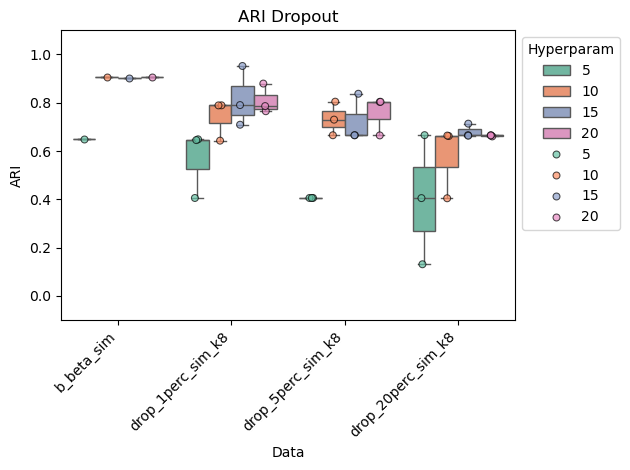

In [134]:
g=sns.boxplot(data=df,x='Data',y='ARI',hue='Hyperparam',
                       palette='Set2',order=['b_beta_sim','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8']) #s=10,edgecolor="black",linewidth=0.75,alpha=0.7,
sns.stripplot(data=df,x='Data',y='ARI',hue='Hyperparam',s=5,edgecolor="black",linewidth=0.75,alpha=0.7,
                       palette='Set2',order=['b_beta_sim','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8'],ax=g,dodge=True) 
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


plt.title('ARI Dropout')  

plt.xticks(rotation = 45,ha='right')
plt.tight_layout()
plt.ylim([-0.1,1.1])
#plt.show()
plt.savefig('ari_dropout.pdf')
#Above 0.8, or 0.65 for best K , where 20% = 20% data corrupted by random dropout on top of molecular dropout from length-biased sampling..
#User can use AIC to select better clustering without knowing labels + intepretable metric provided by meK-Means

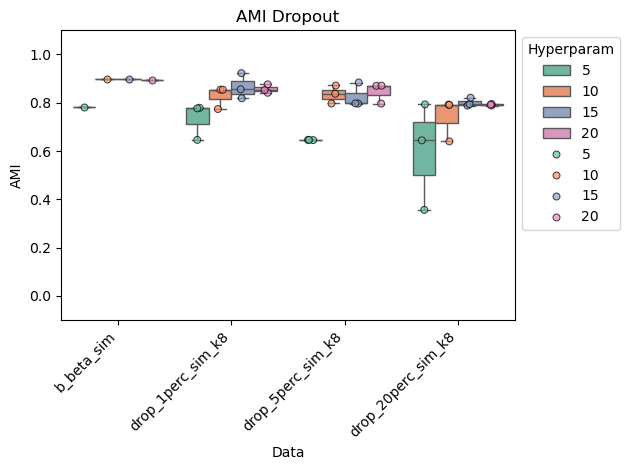

In [154]:
g=sns.boxplot(data=df,x='Data',y='AMI',hue='Hyperparam',
                       palette='Set2',order=['b_beta_sim','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8']) #s=10,edgecolor="black",linewidth=0.75,alpha=0.7,
sns.stripplot(data=df,x='Data',y='AMI',hue='Hyperparam',s=5,edgecolor="black",linewidth=0.75,alpha=0.7,
                       palette='Set2',order=['b_beta_sim','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8'],ax=g,dodge=True) 
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


plt.title('AMI Dropout')  

plt.xticks(rotation = 45,ha='right')
plt.tight_layout()
plt.ylim([-0.1,1.1])
plt.savefig('ami_dropout.pdf')

In [49]:
# g=sns.stripplot(data=df,x='Data',y='Num_Clus',hue='Hyperparam',
#                 s=10,alpha=0.7,edgecolor="black",linewidth=0.75,
#                        palette='Set2',order=['b_beta_sim_k8','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
#        'drop_20perc_sim_k8'])
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


# plt.title('No. Clus Dropout')  

# plt.xticks(rotation = 45,ha='right')
# plt.tight_layout()
# #plt.ylim([-0.1,1.1])
# #plt.show()
# plt.savefig('numclus_dropout.pdf')

In [136]:
df

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,AIC,Num_Clus
0,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_1perc_sim_k8,0.648480,0.779064,-1515.990288,4
1,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",10,1100,drop_1perc_sim_k8,0.789337,0.854169,-1516.193218,6
2,meK-Means,6|6|6|5|6|6|6|6|6|6|6|6|6|6|5|6|6|6|8|6|6|6|6|...,"U,S",15,1100,drop_1perc_sim_k8,0.952292,0.922538,-1515.164622,7
3,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",20,1100,drop_1perc_sim_k8,0.764864,0.841220,-1518.740170,6
4,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_20perc_sim_k8,0.130760,0.355954,-1344.953828,2
5,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",10,1100,drop_20perc_sim_k8,0.404200,0.639894,-1340.913705,3
6,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|0|2|2|2|...,"U,S",15,1100,drop_20perc_sim_k8,0.665642,0.788330,-1338.943996,4
7,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|13|0|0|0...,"U,S",20,1100,drop_20perc_sim_k8,0.660504,0.788564,-1338.810054,4
8,meK-Means,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,"U,S",5,1100,drop_5perc_sim_k8,0.405490,0.645264,-1482.542489,3
9,meK-Means,2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|2|...,"U,S",10,1100,drop_5perc_sim_k8,0.804421,0.871498,-1477.132224,5


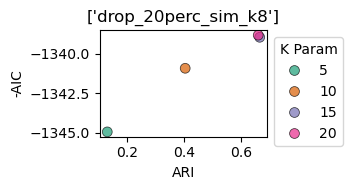

In [144]:
plt.figure(figsize=(3.5,2))
sub_df = df.loc[4:7]
g3=sns.scatterplot(data=sub_df,x='ARI',y='AIC',hue='Hyperparam',palette='Dark2',s=50,
                   alpha=0.7,edgecolor='black')
plt.xlabel('ARI')
plt.ylabel('-AIC')
plt.legend(
      title='K Param')
plt.title(np.unique(sub_df.Data))
sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('ari_aic_drop20.pdf')

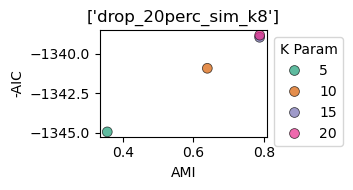

In [145]:
plt.figure(figsize=(3.5,2))
sub_df = df.loc[4:7]
g3=sns.scatterplot(data=sub_df,x='AMI',y='AIC',hue='Hyperparam',palette='Dark2',s=50,
                   alpha=0.7,edgecolor='black')
plt.xlabel('AMI')
plt.ylabel('-AIC')
plt.legend(
      title='K Param')
plt.title(np.unique(sub_df.Data))
sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('ami_aic_drop20.pdf')

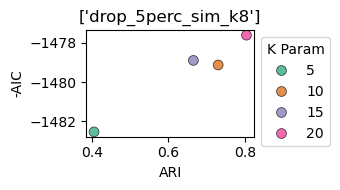

In [146]:
plt.figure(figsize=(3.5,2))
sub_df = df.loc[28:31]
g3=sns.scatterplot(data=sub_df,x='ARI',y='AIC',hue='Hyperparam',palette='Dark2',s=50,
                   alpha=0.7,edgecolor='black')
plt.xlabel('ARI')
plt.ylabel('-AIC')
plt.legend(
      title='K Param')
plt.title(np.unique(sub_df.Data))
sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('ari_aic_drop5.pdf')

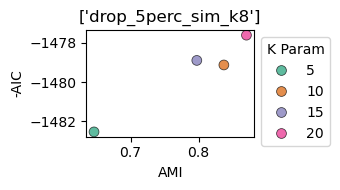

In [149]:
plt.figure(figsize=(3.5,2))
sub_df = df.loc[28:31]
g3=sns.scatterplot(data=sub_df,x='AMI',y='AIC',hue='Hyperparam',palette='Dark2',s=50,
                   alpha=0.7,edgecolor='black')
plt.xlabel('AMI')
plt.ylabel('-AIC')
plt.legend(
      title='K Param')
plt.title(np.unique(sub_df.Data))
sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('ami_aic_drop5.pdf')

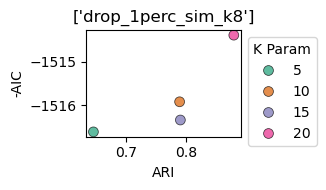

In [152]:
plt.figure(figsize=(3.5,2))
sub_df = df.loc[24:27]
g3=sns.scatterplot(data=sub_df,x='ARI',y='AIC',hue='Hyperparam',palette='Dark2',s=50,
                   alpha=0.7,edgecolor='black')
plt.xlabel('ARI')
plt.ylabel('-AIC')
plt.legend(
      title='K Param')
plt.title(np.unique(sub_df.Data))
sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('ari_aic_drop1.pdf')

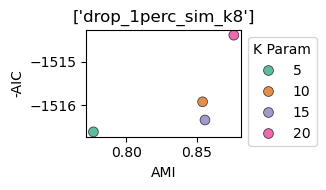

In [153]:
plt.figure(figsize=(3.5,2))
sub_df = df.loc[24:27]
g3=sns.scatterplot(data=sub_df,x='AMI',y='AIC',hue='Hyperparam',palette='Dark2',s=50,
                   alpha=0.7,edgecolor='black')
plt.xlabel('AMI')
plt.ylabel('-AIC')
plt.legend(
      title='K Param')
plt.title(np.unique(sub_df.Data))
sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('ami_aic_drop1.pdf')